In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import sys
sys.path.append("./CLIP")
import clip
import os
import torch
from PIL import Image
from IPython.display import Image as ImageDisplay
from utils import load_pickle
import faiss_utils
from faiss_utils import KNearestFaiss
import numpy as np
from matplotlib.image import imread
from matplotlib.pyplot import figure, imshow, axis
from jupyter_utils import plot_time_jupyter, plot_scores_jupyter

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:

def display_top_query_from_meta(metadata_list, fill=True, score_list=[]):
    list_of_files = [meta.get_path() for meta in metadata_list]
    show_images(list_of_files, fill=fill, score_list=score_list)
        

def show_images(list_of_files, fill=True, score_list=[]):
    block_size = int(len(list_of_files)/20)
    size = (20+20*block_size,20+90*block_size)
    print(size)
    fig = figure(figsize=size, tight_layout=True)
    number_of_files = len(list_of_files)
    for i in range(number_of_files):
        a=fig.add_subplot(number_of_files,3,i+1)
        image = imread(list_of_files[i])
        if fill:
            imshow(image,aspect="auto")
        else:
            imshow(image)
        if len(score_list) > 0:
            title=score_list[i]
            plt.title(title, fontsize=30); 
        axis('off')


def display_query_dict_random(query_dict, class_start=0, class_end=9, fill=False, block_size=2, rank_list=list(range(0, 999, 40)), show_info=None):
    # show_info == None then just show the score
    query_names = list(query_dict.keys())[class_start:class_end+1]
    image_dict = {}
    for query_name in query_names:
        if show_info == 'USER_ID':
            list_of_files, list_of_scores, rank_list = select_from_meta_with_attr(query_dict[query_name]['metadata'], show_info, rank_list=rank_list)
        else:
            list_of_files, list_of_scores, rank_list = select_from_meta(query_dict[query_name]['metadata'], query_dict[query_name]['D'], rank_list=rank_list)
        image_dict[query_name] = list_of_files, list_of_scores
    show_image_dict(image_dict, fill=fill, block_size=block_size)


def display_query_dict(query_dict, class_start=0, class_end=9, fill=False):
    query_names = list(query_dict.keys())[class_start:class_end+1]
    image_dict = {}
    for query_name in query_names:
        list_of_files, list_of_scores, rank_list = select_from_meta(query_dict[query_name]['metadata'], query_dict[query_name]['D'])
        image_dict[query_name] = list_of_files, list_of_scores
    show_image_dict(image_dict, fill=fill)   
    
def select_from_meta(metadata_list, score_list, rank_list=[0, 199, 399, 599, 799, 999]):
    list_of_files = [metadata_list[rank].get_path() for rank in rank_list]
    list_of_scores = [score_list[rank] for rank in rank_list]
    return list_of_files, list_of_scores, rank_list

def select_from_meta_with_attr(metadata_list, attr_name, rank_list=[0, 199, 399, 599, 799, 999]):
    list_of_files = [metadata_list[rank].get_path() for rank in rank_list]
    list_of_scores = [metadata_list[rank].get_metadata().__dict__[attr_name] for rank in rank_list]
    return list_of_files, list_of_scores, rank_list
    

def show_image_dict(image_dict, fill=True, block_size=2):
    size = (20+20*block_size,20+90*block_size)
    size = (20+20*block_size,20+420*block_size)
    print(size)
    fig = figure(figsize=size, tight_layout=True)
    number_of_queries = len(image_dict.keys())
    list_of_files = []
    list_of_scores = []
    list_of_queries = []
    for query in image_dict.keys():
        files, scores= image_dict[query]
        list_of_files += files
        list_of_queries += [query for _ in files]
        list_of_scores += scores
        length_per_query = len(files)
    number_of_files = len(list_of_files)
    
    for i in range(number_of_files):
        a=fig.add_subplot(number_of_files,int(length_per_query/5),i+1)
        if i % length_per_query == 0:
            a.set_ylabel(list_of_queries[i],  fontsize=28)

        image = imread(list_of_files[i])
        if fill:
            imshow(image,aspect="auto")
        else:
            imshow(image)
        if len(list_of_scores) > 0:
            title=list_of_scores[i]
            plt.title(title, fontsize=30); 
        axis('on')

In [3]:

def rank_similiarity_for_label_set(feature_means_dict, feature_name='clip_features', first_bucket_idx=1, last_bucket_idx=10, top_samples=100):
    feature_means = feature_means_dict
    feature_dist = get_feature_dist_func(feature_name)   
    all_query = list(feature_means[first_bucket_idx][feature_name].keys())
    
    query_dist_dict = {}
    for query in all_query:
        score = feature_dist(feature_means[first_bucket_idx][feature_name][query], feature_means[last_bucket_idx][feature_name][query])
#         query_dist_dict[query] = 1 - score if feature_name == 'clip_features' else score
        query_dist_dict[query] = 1 - score
        
    sorted_query = sorted(list(query_dist_dict.keys()), key=lambda x: query_dist_dict[x], reverse=True)
    print(feature_name)
    for query in sorted_query:
#         score = query_dist_dict[query] if feature_name == 'clip_features' else -query_dist_dict[query]
        score = query_dist_dict[query]
        print(f"{query:30s}: {score:.4f}")
    return query_dist_dict

def rank_similiarity_for_label_set_by_mean_distance(feature_means_dict, feature_name='clip_features', first_bucket_idx=1, last_bucket_idx=10, top_samples=100):
    feature_means = feature_means_dict
    feature_dist = get_feature_dist_func(feature_name)   
    all_query = list(feature_means[first_bucket_idx][feature_name].keys())
    
    query_dist_dict = {}
    for query in all_query:
        score = feature_means['analysis'][feature_name][query]['mean_distance']
        query_dist_dict[query] = score
        
    sorted_query = sorted(list(query_dist_dict.keys()), key=lambda x: query_dist_dict[x], reverse=True)
    print(feature_name)
    for query in sorted_query:
#         score = query_dist_dict[query] if feature_name == 'clip_features' else -query_dist_dict[query]
        score = query_dist_dict[query]
        print(f"Mean Distance for {query:30s}: {score:.4f}")
    return query_dist_dict

def rank_similiarity_for_label_set_divide_by_internal_variation(feature_means_dict, feature_name='clip_features', first_bucket_idx=1, last_bucket_idx=10, top_samples=100):
    feature_means = feature_means_dict
    feature_dist = get_feature_dist_func(feature_name)   
    all_query = list(feature_means[first_bucket_idx][feature_name].keys())
    
    query_dist_dict = {}
    for query in all_query:
        score = feature_dist(feature_means[first_bucket_idx][feature_name][query], feature_means[last_bucket_idx][feature_name][query])
        query_dist_dict[query] = {}
        query_dist_dict[query]['first_to_last'] = 1 - score
        query_dist_dict[query]['mean_distance'] = feature_means['analysis'][feature_name][query]['mean_distance'] / 100.
        query_dist_dict[query]['overall'] = query_dist_dict[query]['first_to_last']/query_dist_dict[query]['mean_distance']
        
    sorted_query = sorted(list(query_dist_dict.keys()), key=lambda x: query_dist_dict[x]['overall'], reverse=True)
    print(feature_name)
    for query in sorted_query:
#         score = query_dist_dict[query] if feature_name == 'clip_features' else -query_dist_dict[query]
        score = query_dist_dict[query]['overall']
        mean_distance = query_dist_dict[query]['mean_distance']
        first_to_last = query_dist_dict[query]['first_to_last']
        print(f"{query:30s}: {first_to_last:.4f}/{mean_distance:.4f}={score:.4f}")
    return query_dist_dict

In [4]:
def plot_2d_matrix(matrix, label_ticks, title, min_acc=None, max_acc=None, normalize_by_column=False, plotting_trick=True):
    if plotting_trick:
        matrix_score = matrix.copy()
        matrix = matrix / matrix.mean(axis=0).reshape(1,-1)
        cbar_str = "Test Accuracy"
        format_score = lambda s : f"{s:.2f}"
    elif normalize_by_column:
        matrix = matrix / matrix.mean(axis=0).reshape(1,-1)
        cbar_str = "Test Accuracy / Average Test accuracy per column"
        format_score = lambda s : f"{s:.2f}"
        matrix_score = matrix
    else:
        cbar_str = "Test Accuracy"
        format_score = lambda s : f"{s:.2%}"
        matrix_score = matrix
    
    plt.figure(figsize=(10,10))
    x = ["Test " + n for n in label_ticks]
    y = ['Train ' + n for n in label_ticks]
#     p = plt.imshow(matrix, interpolation='none', cmap=f'Greys', vmin=min_acc, vmax=max_acc)
    p = plt.imshow(matrix, interpolation='none', cmap=f'Blues', vmin=min_acc, vmax=max_acc)
    cbar = plt.colorbar()
    
   
    cbar.ax.set_ylabel(f"{cbar_str}", rotation=-90, va="bottom")
    cbar.ax.set_ylim(bottom=min_acc, top=max_acc)
#         cbar.ax.invert_yaxis()

    plt.xticks(range(len(x)), x, fontsize=11, rotation = -90)
    plt.yticks(range(len(y)), y, fontsize=11)
    plt.title(title, fontsize=15)
    for i in range(len(x)):
        for j in range(len(y)):
            text = plt.text(j, i, format_score(matrix_score[i, j]),
                       ha="center", va="center", color="r")

def eval_2d_matrix(matrix):
#     if normalize_by_column:
#         matrix = matrix / matrix.mean(axis=0).reshape(1,-1)
    backward_transfer = np.tril(matrix, k=-1)
    backward_transfer = np.sum(backward_transfer) / np.count_nonzero(backward_transfer)
    forward_transfer = np.triu(matrix, k=1)
    forward_transfer = np.sum(forward_transfer) / np.count_nonzero(forward_transfer)
    accuracy = np.diag(matrix)
    accuracy = np.mean(accuracy)
    return accuracy, backward_transfer, forward_transfer

def eval_2d_matrix_nap(matrix):
    matrix = matrix[0, :].reshape(1,-1)
    matrix = np.repeat(matrix, matrix.shape[1] ,axis=0)
#     print(matrix)
    return eval_2d_matrix(matrix)

def new_eval_2d_matrix(matrix):
    average_of_lower_columns = []
    average_of_upper_columns = []
    average_of_diagonal = []
    for idx in range(matrix.shape[0]):
        if idx != 0:
            average_of_upper_columns.append(matrix[:idx, idx].mean())
        if idx != matrix.shape[0] - 1:
            average_of_lower_columns.append(matrix[idx+1:, idx].mean())
        average_of_diagonal.append(matrix[idx, idx])
    backward_transfer = sum(average_of_lower_columns) / len(average_of_lower_columns)
    forward_transfer = sum(average_of_upper_columns) / len(average_of_upper_columns)
    accuracy = sum(average_of_diagonal) / len(average_of_diagonal)

    return accuracy, backward_transfer, forward_transfer

def new_eval_2d_matrix_nap(matrix):
    matrix = matrix[0, :].reshape(1,-1)
    matrix = np.repeat(matrix, matrix.shape[1] ,axis=0)
#     print(matrix)
    return new_eval_2d_matrix(matrix)

def final_eval_2d_matrix(matrix):
    average_of_lower_columns = []
    average_of_lower_columns_including_diagonal = []
    average_of_upper_columns_above_plus_one_diagonal = []
    average_of_diagonal = []
    average_of_plus_one_diagonal = []
    average_of_all = []
    for idx in range(matrix.shape[0]):
        if idx > 1:
            average_of_upper_columns_above_plus_one_diagonal.append(matrix[:idx-1, idx].mean())
            average_of_plus_one_diagonal.append(matrix[idx-1, idx])
        if idx != matrix.shape[0] - 1:
            average_of_lower_columns.append(matrix[idx+1:, idx].mean())
        average_of_lower_columns_including_diagonal.append(matrix[idx:, idx].mean())
        average_of_all.append(matrix[:, idx].mean())
        average_of_diagonal.append(matrix[idx, idx])
    backward_transfer = sum(average_of_lower_columns) / len(average_of_lower_columns)
    backward_transfer_with_diag = sum(average_of_lower_columns_including_diagonal) / len(average_of_lower_columns_including_diagonal)
    plus_one_diag = sum(average_of_plus_one_diagonal) / len(average_of_plus_one_diagonal)
    forward_transfer_above_plus_one_diag = sum(average_of_upper_columns_above_plus_one_diagonal) / len(average_of_upper_columns_above_plus_one_diagonal)
    accuracy = sum(average_of_diagonal) / len(average_of_diagonal)
    overall = sum(average_of_all) / len(average_of_all)
    mean = matrix.mean()
    return mean, overall, accuracy, plus_one_diag, backward_transfer, backward_transfer_with_diag, forward_transfer_above_plus_one_diag

def final_eval_2d_matrix_nap(matrix):
    matrix = matrix[0, :].reshape(1,-1)
    matrix = np.repeat(matrix, matrix.shape[1] ,axis=0)
#     print(matrix)
    return final_eval_2d_matrix(matrix)

def dont_forget_eval_2d_matrix(matrix):
    lower_trig_minus_diagonal = []
    upper_trig = []
    average_accuracy = []
    for idx in range(matrix.shape[0]):
        average_accuracy += list(matrix[idx:, idx]).copy()
        if idx != 0:
            upper_trig += list(matrix[:idx, idx]).copy()
        if idx != matrix.shape[0] - 1:
            lower_trig_minus_diagonal += list(matrix[idx+1:, idx] - matrix[idx, idx]).copy()

    backward_transfer = sum(lower_trig_minus_diagonal) / len(lower_trig_minus_diagonal)
    forward_transfer = sum(upper_trig) / len(upper_trig)
    accuracy = sum(average_accuracy) / len(average_accuracy)

    return accuracy, backward_transfer, forward_transfer

def dont_forget_eval_2d_matrix_nap(matrix):
    matrix = matrix[0, :].reshape(1,-1)
    matrix = np.repeat(matrix, matrix.shape[1] ,axis=0)
    return dont_forget_eval_2d_matrix(matrix)

def print_dict(dict):
    str = ""
    for k in dict:
        str += f"  {k}: {dict[k]:.2%}"
    print(str)
    
def print_per_class_accuracy(per_class_accuracy_dict, train_b1=1):
    for b_idx in per_class_accuracy_dict[train_b1]:
        per_class_acc = {}
        for class_name in per_class_accuracy_dict[train_b1][b_idx]:
            per_class_acc[class_name] = per_class_accuracy_dict[train_b1][b_idx][class_name]['corrects'] / \
                per_class_accuracy_dict[train_b1][b_idx][class_name]['counts']
        print(f"Train {train_b1}, Test Bucket {b_idx}")
        print_dict(per_class_acc)

In [5]:
# matrix  = np.array([[0.5, 0.4, 0.4, 0.4],\
#                     [0.8, 0.5, 0.4, 0.4],\
#                     [0.7, 0.65, 0.5, 0.4],\
#                     [0.75, 0.75, 0.65, 0.5]])
matrix  = np.array([[0.2, 0.4, 0.4, 0.4],\
                    [1.0, 0.4, 0.4, 0.4],\
                    [1.0, 1, 0.6, 0.4],\
                    [1.0, 1.0, 1, 0.8]])
mean, overall, diag, plus_one_diag, back, back_with_diag, forward_above_plus_one_diag = final_eval_2d_matrix(matrix)
print(mean, overall, diag, plus_one_diag, back, back_with_diag, forward_above_plus_one_diag)

0.6499999999999999 0.65 0.5 0.4 1.0 0.8 0.4


Report for: cnn_feature dynamic_300 moco_v2_yfcc_feb18_bucket_0_gpu_8_linear_tuned linear_tuned moco_yfcc_feb18_gpu_8_bucket_0
5 runs: Baseline: 94.7463%+-0.0579% (train acc mean + std)  93.0283%+-0.2540% (per sample test acc mean + std), 
single_retrain_matrix         --> Present: 0.892; Backward: 0.881; Forward: 0.865
single_retrain_matrix         --> Present (new): 0.892; Backward (new): 0.879; Forward (new): 0.872
single_retrain_matrix         --> Present (theirs): 0.883; Backward (theirs): -0.013; Forward (theirs): 0.865
single_finetune_matrix        --> Present: 0.916; Backward: 0.917; Forward: 0.886
single_finetune_matrix        --> Present (new): 0.916; Backward (new): 0.918; Forward (new): 0.889
single_finetune_matrix        --> Present (theirs): 0.917; Backward (theirs): 0.006; Forward (theirs): 0.886
curr_prev_retrain_matrix      --> Present: 0.905; Backward: 0.903; Forward: 0.881
curr_prev_retrain_matrix      --> Present (new): 0.905; Backward (new): 0.902; Forward (new): 0

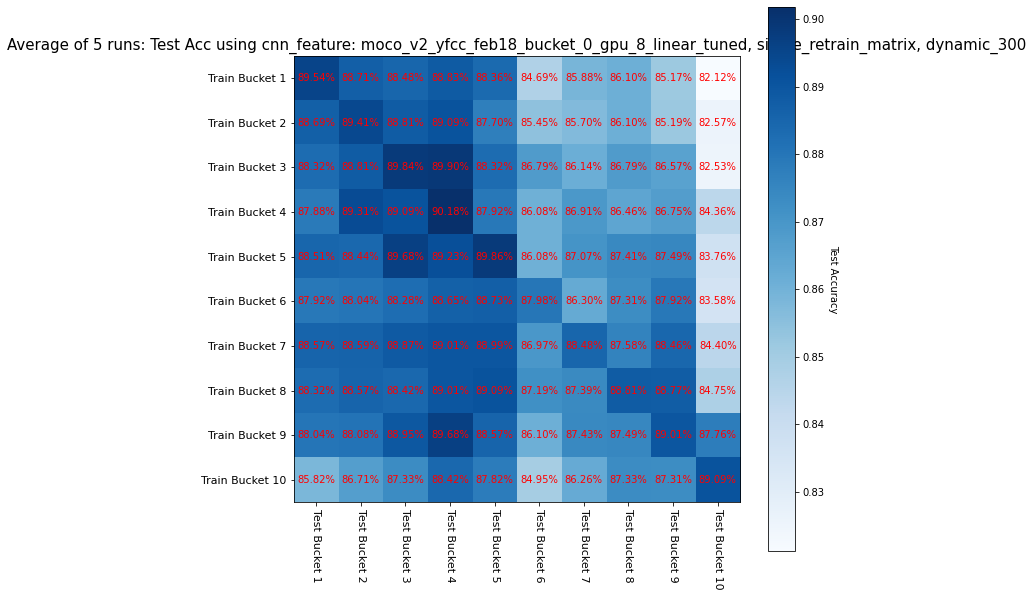

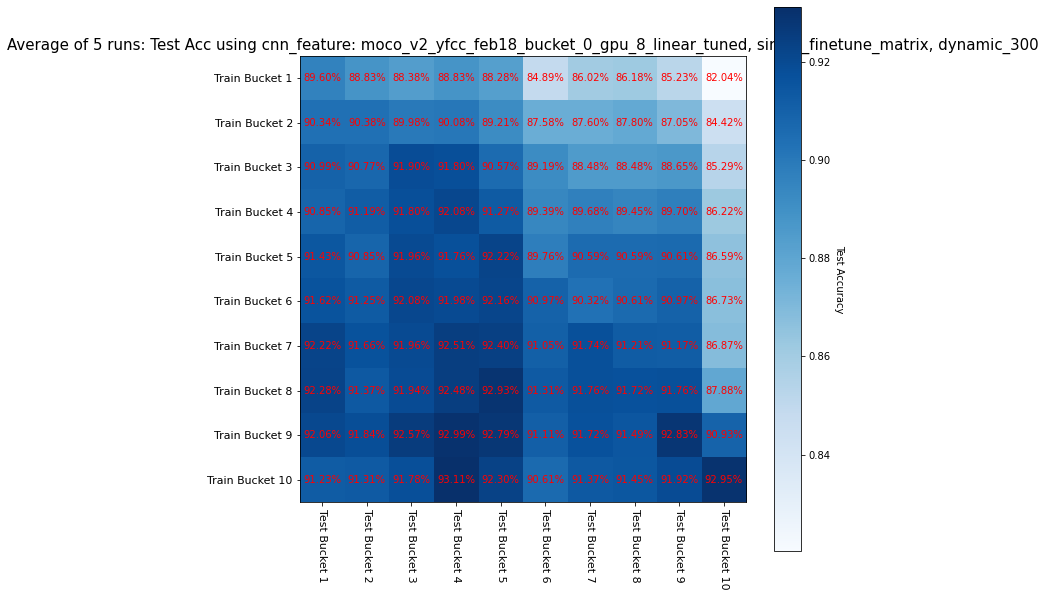

In [6]:
# Plotting all 5 experiment with seed 
name =  "/project_data/ramanan/zhiqiu/yfcc_dynamic_10"
query_title = "none"

use_val_set = False
if use_val_set:
    data_split = "train_0.8_val_0.1_test_0.1"
else:
    data_split = "train_0.7_test_0.3"
excluded_bucket_idx = 0

import train
from train import TRAIN_MODES_CATEGORY, MLP, get_seed_str

LABEL_SETS = ['dynamic_300']
ALL_TRAIN_MODES = [
#                     'linear',
                    
#                     'mlp_tuned',
#                    'cnn_scratch', 'cnn_imgnet', 'cnn_moco', 'cnn_byol', 'cnn_moco_yfcc_feb18_gpu_8_bucket_0',
#                   'moco_v2_imgnet_linear', 
#                   'byol_imgnet_linear', 
                     #'imgnet_linear_tuned', 
                   #'moco_v2_yfcc_feb18_bucket_0_gpu_8_linear',
#                      'linear_tuned', 
#                    'mlp', 
#                     'moco_v2_imgnet_linear_tuned',
#                     'byol_imgnet_linear_tuned', 
#                     'imgnet_linear',
                    'moco_v2_yfcc_feb18_bucket_0_gpu_8_linear_tuned',
#                   'moco_v2_imgnet_mlp', #'moco_v2_imgnet_mlp_tuned', 
#                     'byol_imgnet_mlp', #'byol_imgnet_mlp_tuned', 
#                     'imgnet_mlp', #'imgnet_mlp_tuned', 
#                    'moco_v2_yfcc_feb18_bucket_0_gpu_8_mlp',
#                    'moco_v2_yfcc_feb18_bucket_0_gpu_8_mlp_tuned',
                  ]

# ALL_TRAIN_MODES = [
# #                     'linear', 
# #                    'mlp',
# # #                    'cnn_scratch', 'cnn_imgnet', 'cnn_moco', 'cnn_byol', 'cnn_moco_yfcc_feb18_gpu_8_bucket_0',
# #                   'moco_v2_imgnet_linear',
# #                   'byol_imgnet_linear', 
# #                     'imgnet_linear', 
# #                    'moco_v2_yfcc_feb18_bucket_0_gpu_8_linear',
#                     'moco_v2_yfcc_feb18_bucket_0_gpu_8_linear_tuned',
# #                   'moco_v2_imgnet_mlp', 
# #                     'byol_imgnet_mlp', 
# #                 'imgnet_mlp', 
# #                    'moco_v2_yfcc_feb18_bucket_0_gpu_8_mlp',
# #                    'moco_v2_yfcc_feb18_bucket_0_gpu_8_mlp_tuned',
#                   ]


seed_list = [None, 1, 10, 100, 1000]


for train_mode in ALL_TRAIN_MODES:
    for label_set in LABEL_SETS:
        exp_result_save_path = os.path.join(name, label_set)
        network_type = TRAIN_MODES_CATEGORY[train_mode].network_type
        feature_type = TRAIN_MODES_CATEGORY[train_mode].feature_type
        pretrained_weight = TRAIN_MODES_CATEGORY[train_mode].pretrained_weight
#         b1_b2_accuracy_matrix = np.zeros((len(seed_list), 10,10))
        all_runs = {
            'single_retrain_matrix' : np.zeros((len(seed_list), 10,10)),
            'single_finetune_matrix' : np.zeros((len(seed_list), 10,10)),
            'curr_prev_retrain_matrix' : np.zeros((len(seed_list), 10,10)),
            'curr_prev_finetune_matrix' : np.zeros((len(seed_list), 10,10)),
            'curr_rand_prev_retrain_matrix' : np.zeros((len(seed_list), 10,10)),
            'curr_rand_prev_finetune_matrix' : np.zeros((len(seed_list), 10,10)),
            'seq_retrain_matrix' : np.zeros((len(seed_list), 10,10)),
            'seq_finetune_matrix' : np.zeros((len(seed_list), 10,10)),
            'baseline_train_acc' : np.zeros((len(seed_list))),
            'baseline_test_acc' : np.zeros((len(seed_list))),
            
            'single_retrain_matrix_all' : np.zeros((len(seed_list), 10,10)),
            'single_finetune_matrix_all' : np.zeros((len(seed_list), 10,10)),
            'curr_prev_retrain_matrix_all' : np.zeros((len(seed_list), 10,10)),
            'curr_prev_finetune_matrix_all' : np.zeros((len(seed_list), 10,10)),
            'seq_retrain_matrix_all' : np.zeros((len(seed_list), 10,10)),
            'seq_finetune_matrix_all' : np.zeros((len(seed_list), 10,10)),
        }
        for idx, seed in enumerate(seed_list):
            seed_str = get_seed_str(seed)
            
            results_dict_curr_and_prev_retrain_path = os.path.join(exp_result_save_path,
                                                                       f"results_dict_curr_and_prev_retrain_{data_split}_{train_mode}_{seed_str}_ex_{excluded_bucket_idx}.pickle")
            results_dict_curr_and_prev_finetune_path = os.path.join(exp_result_save_path,
                                                                   f"results_dict_curr_and_prev_finetune_{data_split}_{train_mode}_{seed_str}_ex_{excluded_bucket_idx}.pickle")
            results_dict_sequential_retrain_path = os.path.join(exp_result_save_path,
                                                                   f"results_dict_sequential_retrain_{data_split}_{train_mode}_{seed_str}_ex_{excluded_bucket_idx}.pickle")
            results_dict_sequential_finetune_path = os.path.join(exp_result_save_path,
                                                                   f"results_dict_sequential_finetune_{data_split}_{train_mode}_{seed_str}_ex_{excluded_bucket_idx}.pickle")
            results_dict_all_path = os.path.join(exp_result_save_path,
                                                                   f"results_dict_all_{data_split}_{train_mode}_{seed_str}_ex_{excluded_bucket_idx}.pickle")
            results_dict_single_retrain_path = os.path.join(exp_result_save_path,
                                                                   f"results_dict_single_{data_split}_{train_mode}_{seed_str}_ex_{excluded_bucket_idx}.pickle")
            results_dict_single_finetune_path = os.path.join(exp_result_save_path,
                                                                   f"results_dict_single_finetune_{data_split}_{train_mode}_{seed_str}_ex_{excluded_bucket_idx}.pickle")
            results_dict_curr_and_random_prev_retrain_path = os.path.join(exp_result_save_path,
                                                            f"results_dict_curr_and_random_prev_retrain_{data_split}_{train_mode}_{seed_str}_ex_{excluded_bucket_idx}.pickle")
        
            results_dict_curr_and_random_prev_finetune_path = os.path.join(exp_result_save_path,
                                                                           f"results_dict_curr_and_random_prev_finetune_{data_split}_{train_mode}_{seed_str}_ex_{excluded_bucket_idx}.pickle")
            
            results_dict_curr_and_prev_retrain_path_all = os.path.join(exp_result_save_path,
                                                                       f"results_dict_curr_and_prev_with_all_retrain_{data_split}_{train_mode}_{seed_str}_ex_{excluded_bucket_idx}.pickle")
            results_dict_curr_and_prev_finetune_path_all = os.path.join(exp_result_save_path,
                                                                   f"results_dict_curr_and_prev_with_all_finetune_{data_split}_{train_mode}_{seed_str}_ex_{excluded_bucket_idx}.pickle")
            results_dict_sequential_retrain_path_all = os.path.join(exp_result_save_path,
                                                                   f"results_dict_sequential_with_all_retrain_{data_split}_{train_mode}_{seed_str}_ex_{excluded_bucket_idx}.pickle")
            results_dict_sequential_finetune_path_all = os.path.join(exp_result_save_path,
                                                                   f"results_dict_sequential_with_all_finetune_{data_split}_{train_mode}_{seed_str}_ex_{excluded_bucket_idx}.pickle")
            results_dict_single_retrain_path_all = os.path.join(exp_result_save_path,
                                                                   f"results_dict_single_with_all_{data_split}_{train_mode}_{seed_str}_ex_{excluded_bucket_idx}.pickle")
            results_dict_single_finetune_path_all = os.path.join(exp_result_save_path,
                                                                   f"results_dict_single_with_all_finetune_{data_split}_{train_mode}_{seed_str}_ex_{excluded_bucket_idx}.pickle")


            results_dict_all = load_pickle(results_dict_all_path)
            if type(results_dict_all) == type(None):
                print(f"{results_dict_all_path} does not exist yet")
                import pdb; pdb.set_trace()
                continue
            
            results_dict_curr_and_random_prev_retrain = load_pickle(results_dict_curr_and_random_prev_retrain_path)
            if type(results_dict_curr_and_random_prev_retrain) == type(None):
                print(f"{results_dict_curr_and_random_prev_retrain_path} does not exist yet")
                if not use_val_set:
                    import pdb; pdb.set_trace()
                    continue
            
            results_dict_curr_and_random_prev_finetune = load_pickle(results_dict_curr_and_random_prev_finetune_path)
            if type(results_dict_curr_and_random_prev_finetune) == type(None):
                print(f"{results_dict_curr_and_random_prev_finetune_path} does not exist yet")
                if not use_val_set:
                    import pdb; pdb.set_trace()
                    continue
            
            results_dict_curr_and_prev_retrain = load_pickle(results_dict_curr_and_prev_retrain_path)
            if type(results_dict_curr_and_prev_retrain) == type(None):
                print(f"{results_dict_curr_and_prev_retrain_path} does not exist yet")
                if not use_val_set:
                    import pdb; pdb.set_trace()
                    continue
            
            results_dict_curr_and_prev_finetune = load_pickle(results_dict_curr_and_prev_finetune_path)
            if type(results_dict_curr_and_prev_finetune) == type(None):
                print(f"{results_dict_curr_and_prev_finetune_path} does not exist yet")
                if not use_val_set:
                    import pdb; pdb.set_trace()
                    continue
            
            results_dict_sequential_finetune = load_pickle(results_dict_sequential_finetune_path)
            if type(results_dict_sequential_finetune) == type(None):
                print(f"{results_dict_sequential_finetune_path} does not exist yet")
                if not use_val_set:
                    import pdb; pdb.set_trace()
                    continue
            
            results_dict_sequential_retrain = load_pickle(results_dict_sequential_retrain_path)
            if type(results_dict_sequential_retrain) == type(None):
                print(f"{results_dict_sequential_retrain_path} does not exist yet")
                if not use_val_set:
                    import pdb; pdb.set_trace()
                    continue
            
            results_dict_single_retrain = load_pickle(results_dict_single_retrain_path)
            if type(results_dict_single_retrain) == type(None):
                print(f"{results_dict_single_retrain_path} does not exist yet")
                import pdb; pdb.set_trace()
                continue
            
            results_dict_single_finetune = load_pickle(results_dict_single_finetune_path)
            if type(results_dict_single_finetune) == type(None):
                print(f"{results_dict_single_finetune_path} does not exist yet")
                import pdb; pdb.set_trace()
                continue
                
                
            results_dict_curr_and_prev_retrain_all = load_pickle(results_dict_curr_and_prev_retrain_path_all)
            if type(results_dict_curr_and_prev_retrain_all) == type(None):
                print(f"{results_dict_curr_and_prev_retrain_path_all} does not exist yet")
                if not use_val_set:
                    import pdb; pdb.set_trace()
                    continue
            
            results_dict_curr_and_prev_finetune_all = load_pickle(results_dict_curr_and_prev_finetune_path_all)
            if type(results_dict_curr_and_prev_finetune_all) == type(None):
                print(f"{results_dict_curr_and_prev_finetune_path_all} does not exist yet")
                if not use_val_set:
                    import pdb; pdb.set_trace()
                    continue
            
            results_dict_sequential_finetune_all = load_pickle(results_dict_sequential_finetune_path_all)
            if type(results_dict_sequential_finetune_all) == type(None):
                print(f"{results_dict_sequential_finetune_path_all} does not exist yet")
                if not use_val_set:
                    import pdb; pdb.set_trace()
                    continue
            
            results_dict_sequential_retrain_all = load_pickle(results_dict_sequential_retrain_path_all)
            if type(results_dict_sequential_retrain_all) == type(None):
                print(f"{results_dict_sequential_retrain_path_all} does not exist yet")
                if not use_val_set:
                    import pdb; pdb.set_trace()
                    continue
            
            results_dict_single_retrain_all = load_pickle(results_dict_single_retrain_path_all)
            if type(results_dict_single_retrain_all) == type(None):
                print(f"{results_dict_single_retrain_path_all} does not exist yet")
                import pdb; pdb.set_trace()
                continue
            
            results_dict_single_finetune_all = load_pickle(results_dict_single_finetune_path_all)
            if type(results_dict_single_finetune_all) == type(None):
                print(f"{results_dict_single_finetune_path_all} does not exist yet")
                import pdb; pdb.set_trace()
                continue
            
            all_runs['single_retrain_matrix'][idx] = results_dict_single_retrain['b1_b2_accuracy_matrix']
            all_runs['single_finetune_matrix'][idx] = results_dict_single_finetune['b1_b2_accuracy_matrix']
            if not use_val_set:
                all_runs['curr_prev_retrain_matrix'][idx] = results_dict_curr_and_prev_retrain['b1_b2_accuracy_matrix']
                all_runs['curr_prev_finetune_matrix'][idx] = results_dict_curr_and_prev_finetune['b1_b2_accuracy_matrix']
                all_runs['curr_rand_prev_retrain_matrix'][idx] = results_dict_curr_and_random_prev_retrain['b1_b2_accuracy_matrix']
                all_runs['curr_rand_prev_finetune_matrix'][idx] = results_dict_curr_and_random_prev_finetune['b1_b2_accuracy_matrix']
                all_runs['seq_retrain_matrix'][idx] = results_dict_sequential_retrain['b1_b2_accuracy_matrix']
                all_runs['seq_finetune_matrix'][idx] = results_dict_sequential_finetune['b1_b2_accuracy_matrix']
#                 seq_b1_b2_per_class_accuracy_dict = results_dict_sequential_finetune['b1_b2_per_class_accuracy_dict']
# #                 import pdb; pdb.set_trace()
#                 print_per_class_accuracy(seq_b1_b2_per_class_accuracy_dict)
            all_runs['baseline_train_acc'][idx] = results_dict_all['accuracy_matrix']['train']
            all_runs['baseline_test_acc'][idx] = results_dict_all['accuracy_matrix']['test']
#             import pdb; pdb.set_trace()
            
            all_runs['single_retrain_matrix_all'][idx] = results_dict_single_retrain_all['b1_b2_accuracy_matrix_all']
            all_runs['single_finetune_matrix_all'][idx] = results_dict_single_finetune_all['b1_b2_accuracy_matrix_all']
            if not use_val_set:
                all_runs['curr_prev_retrain_matrix_all'][idx] = results_dict_curr_and_prev_retrain_all['b1_b2_accuracy_matrix_all']
                all_runs['curr_prev_finetune_matrix_all'][idx] = results_dict_curr_and_prev_finetune_all['b1_b2_accuracy_matrix_all']
                all_runs['seq_retrain_matrix_all'][idx] = results_dict_sequential_retrain_all['b1_b2_accuracy_matrix_all']
                all_runs['seq_finetune_matrix_all'][idx] = results_dict_sequential_finetune_all['b1_b2_accuracy_matrix_all']
        
        try:
            all_bucket = [i for i in list(results_dict_single_retrain['accuracy'].keys())]
        except:
            import pdb; pdb.set_trace()
            continue
        
        all_bucket_str_single = [f"Bucket {i}" for i in all_bucket]
        all_bucket_str_seq = [f"Bucket 1 to {i}" for i in all_bucket]
        all_bucket_str_twob = [f"Bucket {max(i-1, 1)} to {i}" for i in all_bucket]
        all_bucket_str_rand_twob = [f"(Random) Bucket {max(i-1, 1)} to {i}" for i in all_bucket]
        
        all_runs['single_retrain_matrix'] = all_runs['single_retrain_matrix'].mean(axis=0)
        all_runs['single_finetune_matrix'] = all_runs['single_finetune_matrix'].mean(axis=0)
        all_runs['curr_prev_retrain_matrix'] = all_runs['curr_prev_retrain_matrix'].mean(axis=0)
        all_runs['curr_prev_finetune_matrix'] = all_runs['curr_prev_finetune_matrix'].mean(axis=0)
        all_runs['curr_rand_prev_retrain_matrix'] = all_runs['curr_rand_prev_retrain_matrix'].mean(axis=0)
        all_runs['curr_rand_prev_finetune_matrix'] = all_runs['curr_rand_prev_finetune_matrix'].mean(axis=0)
        all_runs['seq_retrain_matrix'] = all_runs['seq_retrain_matrix'].mean(axis=0)
        all_runs['seq_finetune_matrix'] = all_runs['seq_finetune_matrix'].mean(axis=0)
        
        all_runs['single_retrain_matrix_all'] = all_runs['single_retrain_matrix_all'].mean(axis=0)
        all_runs['single_finetune_matrix_all'] = all_runs['single_finetune_matrix_all'].mean(axis=0)
        all_runs['curr_prev_retrain_matrix_all'] = all_runs['curr_prev_retrain_matrix_all'].mean(axis=0)
        all_runs['curr_prev_finetune_matrix_all'] = all_runs['curr_prev_finetune_matrix_all'].mean(axis=0)
        all_runs['seq_retrain_matrix_all'] = all_runs['seq_retrain_matrix_all'].mean(axis=0)
        all_runs['seq_finetune_matrix_all'] = all_runs['seq_finetune_matrix_all'].mean(axis=0)
                    
        plot_2d_matrix(all_runs['single_retrain_matrix'],
                       all_bucket_str_single,
                       title=f"Average of {len(seed_list)} runs: Test Acc using {feature_type}: {train_mode}, single_retrain_matrix, {label_set}",
                       normalize_by_column=False,
                       plotting_trick=False
        )
        
        plot_2d_matrix(all_runs['single_finetune_matrix'],
                       all_bucket_str_single,
                       title=f"Average of {len(seed_list)} runs: Test Acc using {feature_type}: {train_mode}, single_finetune_matrix, {label_set}",
                       normalize_by_column=False,
                       plotting_trick=False
        )
        
#         plot_2d_matrix(all_runs['curr_prev_retrain_matrix'],
#                        all_bucket_str_twob,
#                        title=f"Average of {len(seed_list)} runs: Test Acc using {feature_type}: {train_mode}, curr_prev_retrain_matrix, {label_set}",
#                        normalize_by_column=False,
#                        plotting_trick=False
#         )
        
#         plot_2d_matrix(all_runs['curr_prev_finetune_matrix'],
#                        all_bucket_str_twob,
#                        title=f"Average of {len(seed_list)} runs: Test Acc using {feature_type}: {train_mode}, curr_prev_finetune_matrix, {label_set}",
#                        normalize_by_column=False,
#                        plotting_trick=False
#         )
        
#         plot_2d_matrix(all_runs['curr_rand_prev_retrain_matrix'],
#                        all_bucket_str_rand_twob,
#                        title=f"Average of {len(seed_list)} runs: Test Acc using {feature_type}: {train_mode}, curr_rand_prev_retrain_matrix, {label_set}",
#                        normalize_by_column=False,
#                        plotting_trick=False
#         )
        
#         plot_2d_matrix(all_runs['curr_rand_prev_finetune_matrix'],
#                        all_bucket_str_rand_twob,
#                        title=f"Average of {len(seed_list)} runs: Test Acc using {feature_type}: {train_mode}, curr_rand_prev_finetune_matrix, {label_set}",
#                        normalize_by_column=False,
#                        plotting_trick=False
#         )
        
#         plot_2d_matrix(all_runs['single_retrain_matrix'],
#                        all_bucket_str_seq,
#                        title=f"Average of {len(seed_list)} runs: Test Acc using {feature_type}: {train_mode}, seq_retrain_matrix, {label_set}",
#                        normalize_by_column=False,
#                        plotting_trick=False
#         )
        
#         plot_2d_matrix(all_runs['seq_finetune_matrix'],
#                        all_bucket_str_seq,
#                        title=f"Average of {len(seed_list)} runs: Test Acc using {feature_type}: {train_mode}, seq_finetune_matrix, {label_set}",
#                        normalize_by_column=False,
#                        plotting_trick=False
#         )
        
        metrics = ['single_retrain_matrix', 'single_finetune_matrix', 'curr_prev_retrain_matrix', 'curr_prev_finetune_matrix', 'curr_rand_prev_retrain_matrix', 'curr_rand_prev_finetune_matrix', 'seq_retrain_matrix', 'seq_finetune_matrix']
        print(f"Report for: {feature_type} {label_set} {train_mode} {network_type} {pretrained_weight}")
        print(f"{len(seed_list)} runs: Baseline: {all_runs['baseline_train_acc'].mean():.4%}+-{all_runs['baseline_train_acc'].std():.4%} (train acc mean + std) ",
              f"{all_runs['baseline_test_acc'].mean():.4%}+-{all_runs['baseline_test_acc'].std():.4%} (per sample test acc mean + std), ")
        for metric in metrics:
#             import pdb; pdb.set_trace()
            accuracy, backward_transfer, forward_transfer = eval_2d_matrix(all_runs[metric])
            print(f"{metric:30s}--> Present: {accuracy:.3f}; Backward: {backward_transfer:.3f}; Forward: {forward_transfer:.3f}")
            accuracy, backward_transfer, forward_transfer = new_eval_2d_matrix(all_runs[metric])
            print(f"{metric:30s}--> Present (new): {accuracy:.3f}; Backward (new): {backward_transfer:.3f}; Forward (new): {forward_transfer:.3f}")
            accuracy, backward_transfer, forward_transfer = dont_forget_eval_2d_matrix(all_runs[metric])
            print(f"{metric:30s}--> Present (theirs): {accuracy:.3f}; Backward (theirs): {backward_transfer:.3f}; Forward (theirs): {forward_transfer:.3f}")
        for metric in metrics:
            accuracy_nap, backward_transfer_nap, forward_transfer_nap = eval_2d_matrix_nap(all_runs[metric])
            print(f"{metric:30s}--> (NAP): Present: {accuracy_nap:.3f}; Backward: {backward_transfer_nap:.3f}; Forward: {forward_transfer_nap:.3f}")
            accuracy_nap, backward_transfer_nap, forward_transfer_nap = new_eval_2d_matrix_nap(all_runs[metric])
            print(f"{metric:30s}--> (NAP): Present (new): {accuracy_nap:.3f}; Backward (new): {backward_transfer_nap:.3f}; Forward (new): {forward_transfer_nap:.3f}")
            accuracy_nap, backward_transfer_nap, forward_transfer_nap = dont_forget_eval_2d_matrix_nap(all_runs[metric])
            print(f"{metric:30s}--> (NAP): Present (theirs): {accuracy_nap:.3f}; Backward (theirs): {backward_transfer_nap:.3f}; Forward (theirs): {forward_transfer_nap:.3f}")
        for metric in metrics:
            latex_str = ""
            mean, overall, diag, plus_one_diag, back, back_with_diag, forward_above_plus_one_diag = final_eval_2d_matrix(all_runs[metric])
            print(f"{metric:30s}--> Mean: {mean:.3f}; Overall: {overall:.3f}; Diag: {diag:.3f}; +1Diag: {plus_one_diag:.3f}; back: {back:.3f}; back_diag: {back_with_diag:.3f}; for: {forward_above_plus_one_diag:.3f}")
            latex_str += f"${mean:.3f}$ & ${overall:.3f}$ & ${diag:.3f}$ & ${plus_one_diag:.3f}$ & ${back:.3f}$ & ${back_with_diag:.3f}$ & ${forward_above_plus_one_diag:.3f}$"
            print(latex_str)
        for metric in metrics:
            mean, overall, diag, plus_one_diag, back, back_with_diag, forward_above_plus_one_diag = final_eval_2d_matrix_nap(all_runs[metric])
            print(f"{metric:30s} (NAPPING!!)--> Mean: {mean:.3f}; Overall: {overall:.3f}; Diag: {diag:.3f}; +1Diag: {plus_one_diag:.3f}; back: {back:.3f}; back_diag: {back_with_diag:.3f}; for: {forward_above_plus_one_diag:.3f}")
        
        
        metrics = ['single_retrain_matrix_all', 'single_finetune_matrix_all', 'curr_prev_retrain_matrix_all', 'curr_prev_finetune_matrix_all', 'seq_retrain_matrix_all', 'seq_finetune_matrix_all']
        for metric in metrics:
            latex_str = ""
            mean, overall, diag, plus_one_diag, back, back_with_diag, forward_above_plus_one_diag = final_eval_2d_matrix(all_runs[metric])
            print(f"{metric:30s} (ALL) --> +1Diag: {plus_one_diag:.3f}; for: {forward_above_plus_one_diag:.3f}")
            latex_str += f"${plus_one_diag:.3f}$ & ${forward_above_plus_one_diag:.3f}$"
            print(latex_str)
        
        for metric in metrics:
            latex_str = ""
            mean, overall, diag, plus_one_diag, back, back_with_diag, forward_above_plus_one_diag = final_eval_2d_matrix_nap(all_runs[metric])
            print(f"{metric:30s} (ALL NAP) --> +1Diag: {plus_one_diag:.3f}; for: {forward_above_plus_one_diag:.3f}")
            latex_str += f"${plus_one_diag:.3f}$ & ${forward_above_plus_one_diag:.3f}$"
            print(latex_str)


        print(f"{metric:25s}(NAP)--> : Present: {accuracy_nap:.2%}; Backward: {backward_transfer_nap:.2%}; Forward: {forward_transfer_nap:.2%}")
        
            

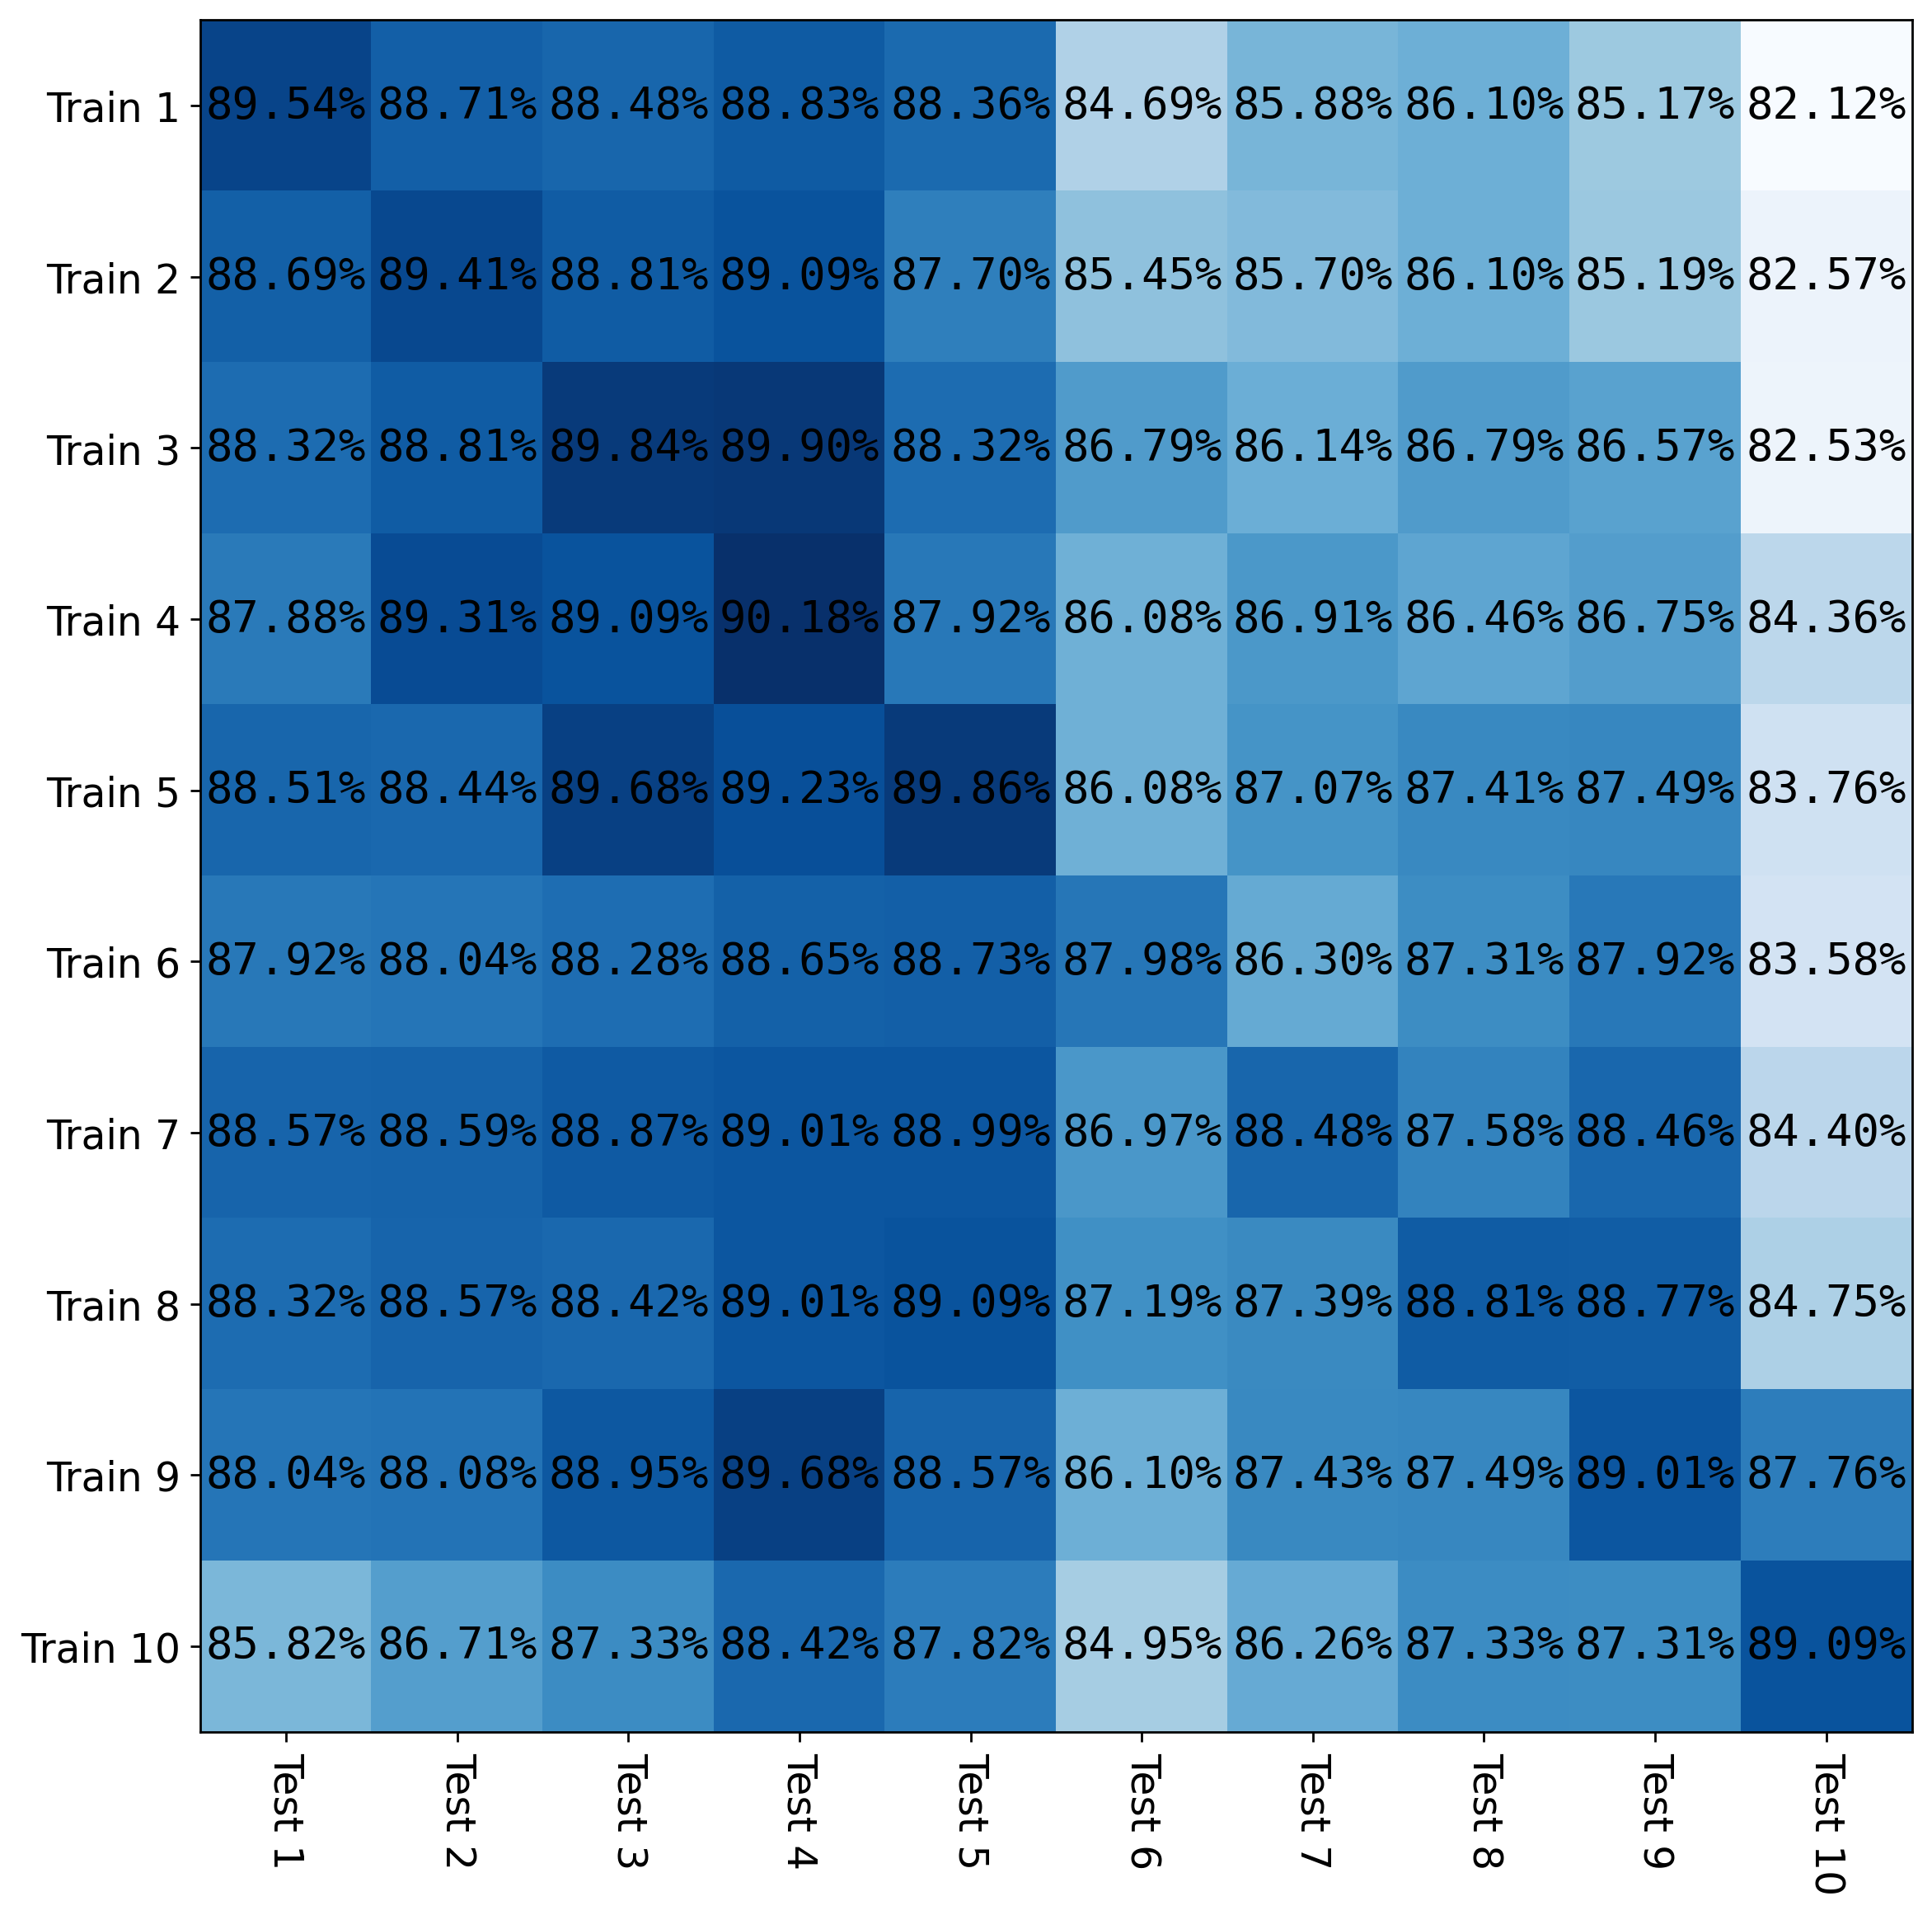

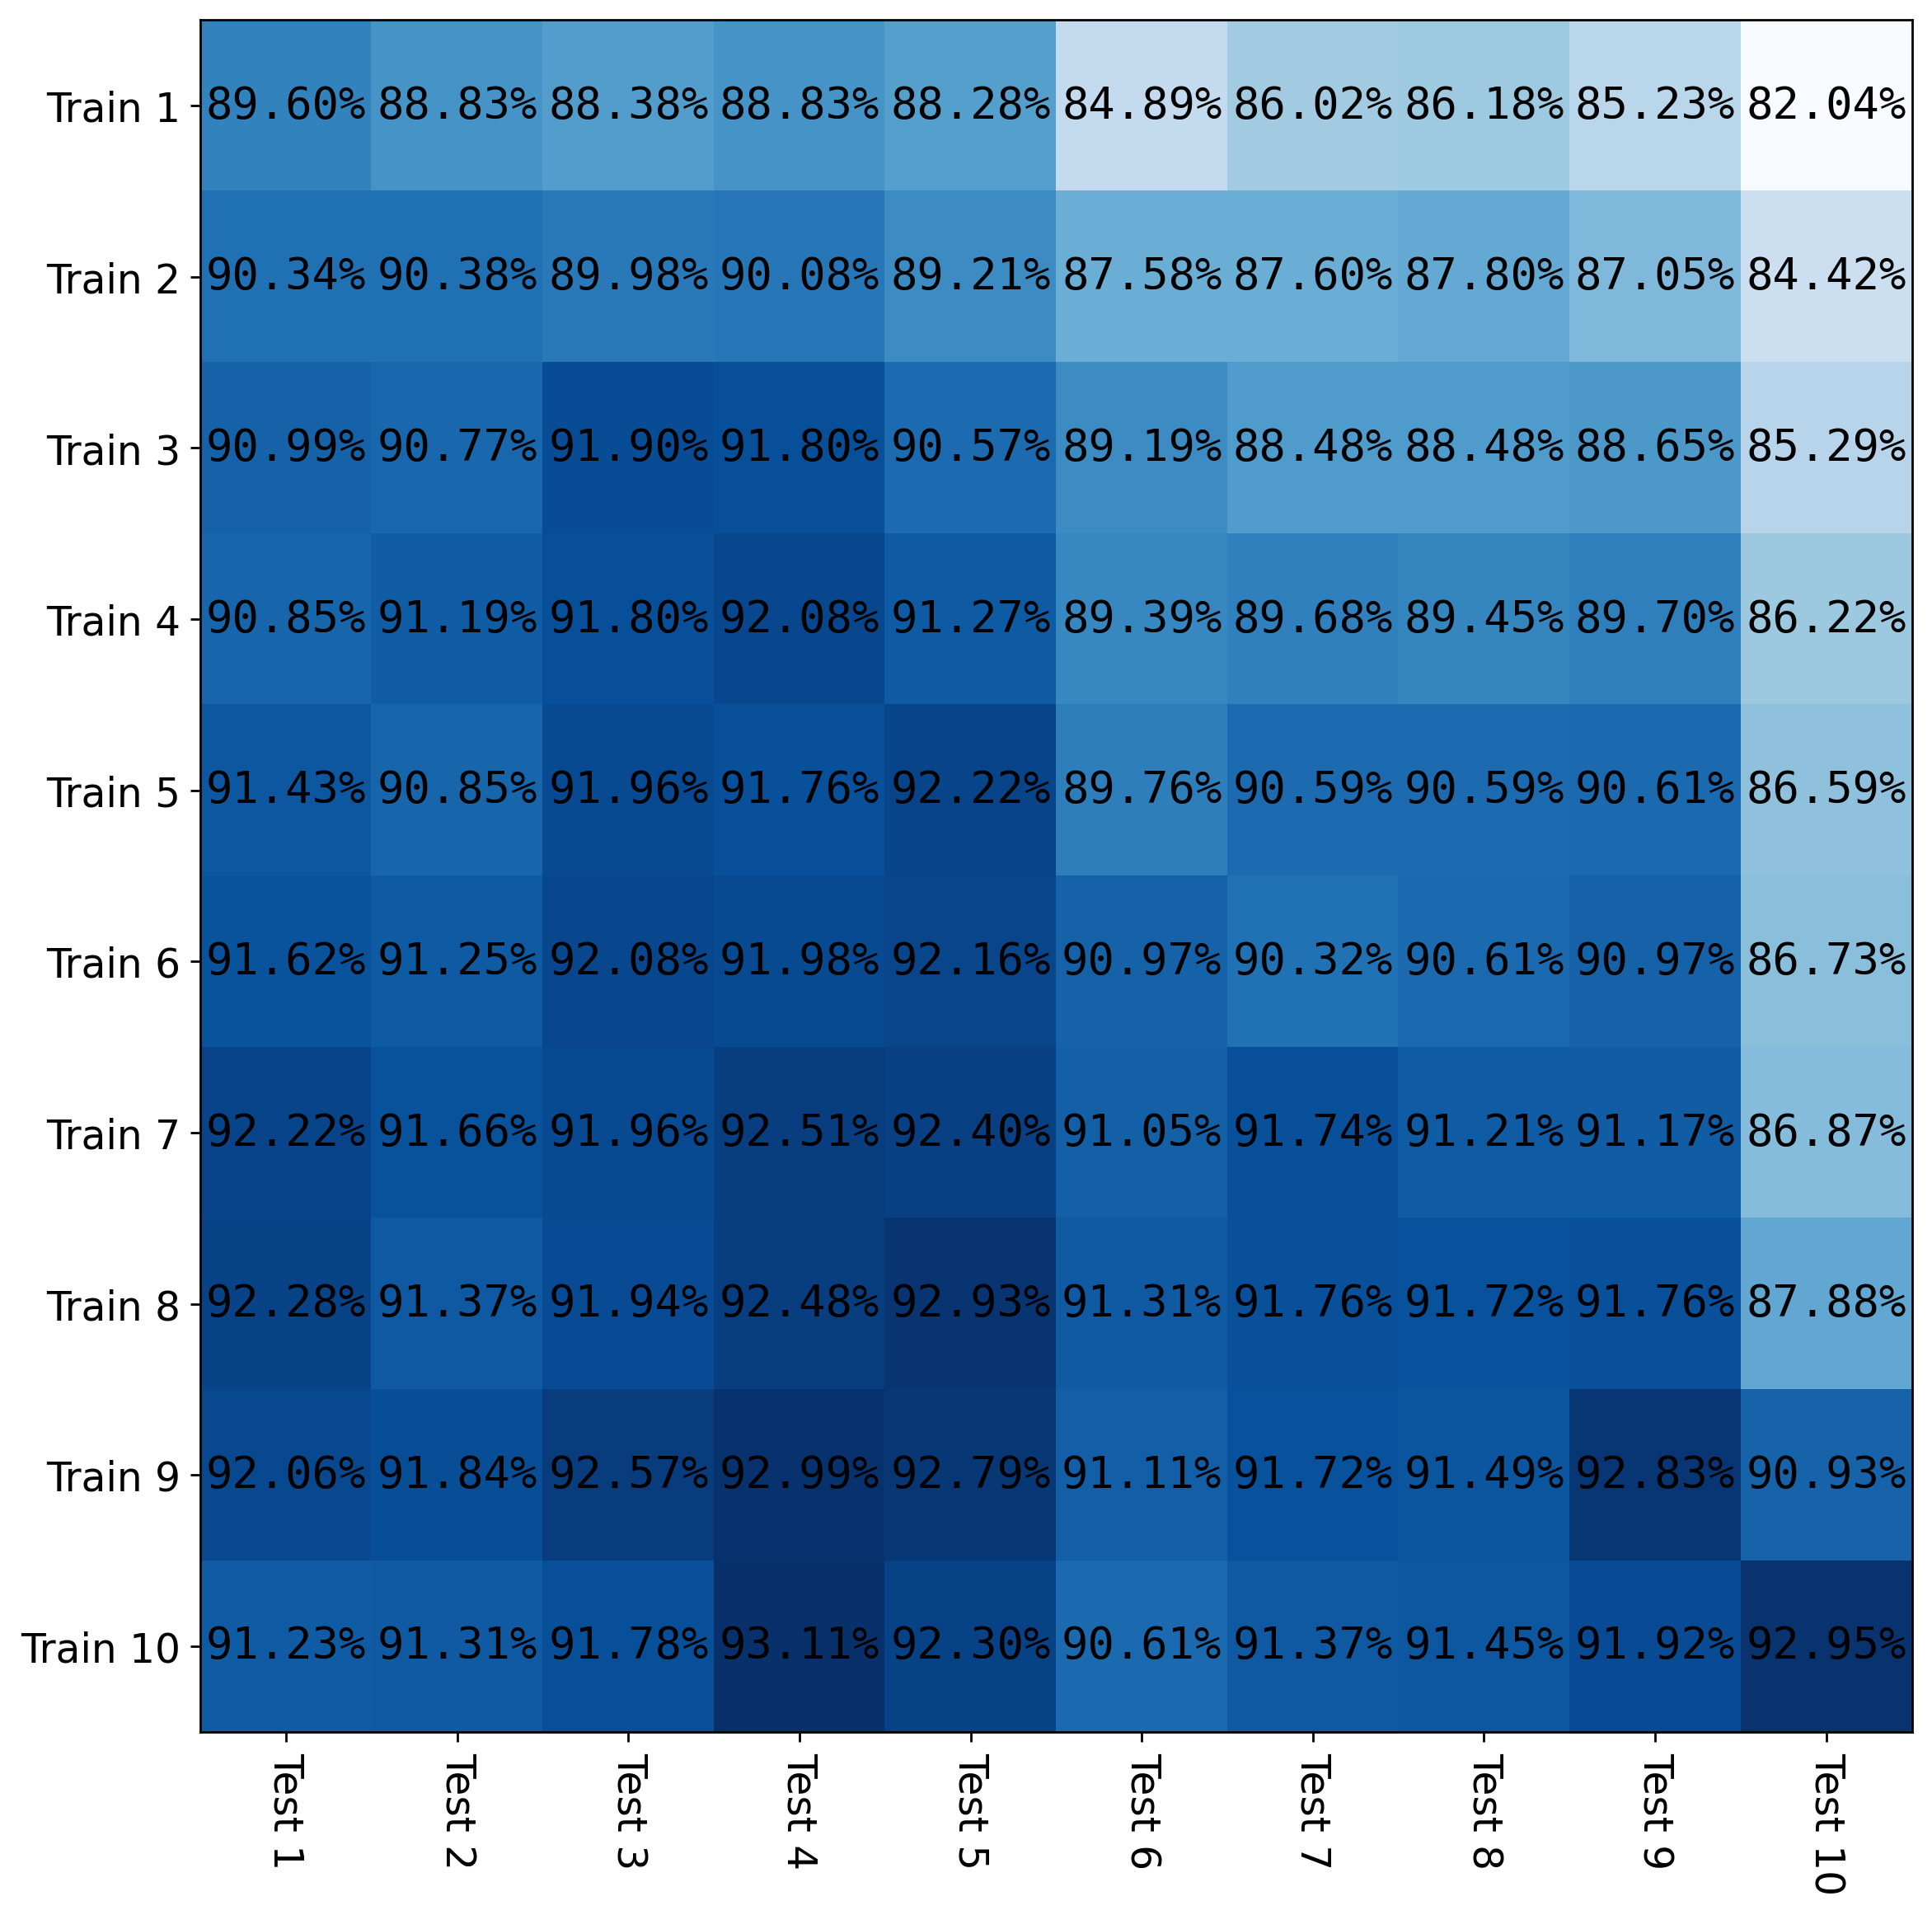

In [7]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 250

def plot_for_paper(matrix, label_ticks, title, min_acc=None, max_acc=None, normalize_by_column=False, plotting_trick=True):
    cbar_str = "Test Accuracy"
    format_score = lambda s : f"{s:.2%}"
    matrix_score = matrix
    
    plt.figure(figsize=(11,11))
    x = ["Test " + str(n) for n in range(1,11)]
    y = ['Train ' + str(n) for n in range(1,11)]
#     p = plt.imshow(matrix, interpolation='none', cmap=f'Greys', vmin=min_acc, vmax=max_acc)
    p = plt.imshow(matrix, interpolation='none', cmap=f'Blues', vmin=min_acc, vmax=max_acc)
#     cbar = plt.colorbar()
    
   
#     cbar.ax.set_ylabel(f"{cbar_str}", rotation=-90, va="bottom")
#     cbar.ax.set_ylim(bottom=min_acc, top=max_acc)
#         cbar.ax.invert_yaxis()

    plt.xticks(range(len(x)), x, fontsize=14, rotation = -90)
    plt.yticks(range(len(y)), y, fontsize=14)
    plt.title(title, fontsize=20)
    for i in range(len(x)):
        for j in range(len(y)):
            text = plt.text(j, i, format_score(matrix_score[i, j]),
                       ha="center", va="center", color="black", fontsize=15.5, family='monospace')


plot_for_paper(
                    all_runs['single_retrain_matrix'],
#     all_runs['seq_retrain_matrix'],
                       all_bucket_str_single,
#                        title=f"Train-Test Accuracy Matrix for Linear Classification (From Scratch)",
                       title="",
                       normalize_by_column=False,
                       plotting_trick=False
        )
        
plot_for_paper(
                all_runs['single_finetune_matrix'],
#                 all_runs['seq_finetune_matrix'],
               all_bucket_str_single,
#                title=f"Train-Test Accuracy Matrix for Linear Classification (Finetuning)",
               title="",
               normalize_by_column=False,
               plotting_trick=False
)

In [8]:
# Plotting all 5 experiment with seed 
name =  "/project_data/ramanan/zhiqiu/yfcc_dynamic_10"
query_title = "none"


use_val_set = False
if use_val_set:
    data_split = "train_0.8_val_0.1_test_0.1"
else:
    data_split = "train_0.7_test_0.3"
    
excluded_bucket_idx = 0

import train
from train import TRAIN_MODES_CATEGORY, MLP, get_seed_str

label_set = 'dynamic_300'
ALL_TRAIN_MODES = [
                   'linear', 'linear_tuned',
                   'mlp', 'mlp_tuned',
                   'cnn_scratch', 'cnn_scratch_lower_lr',
#     'cnn_imgnet', 'cnn_moco', 'cnn_byol',
                    
                  'cnn_moco_yfcc_feb18_gpu_8_bucket_0', 'cnn_moco_yfcc_feb18_gpu_8_bucket_0_lower_lr',

                  'moco_v2_imgnet_linear', 'byol_imgnet_linear', 'imgnet_linear', 
                  'moco_v2_imgnet_linear_tuned', 'byol_imgnet_linear_tuned', 'imgnet_linear_tuned', 
                  'moco_v2_yfcc_feb18_bucket_0_gpu_8_linear', 'moco_v2_yfcc_feb18_bucket_0_gpu_8_linear_tuned', 'moco_v2_yfcc_feb18_bucket_0_gpu_8_linear_tuned_2',
                  'moco_v2_imgnet_mlp', 'byol_imgnet_mlp', 'imgnet_mlp_tuned', 'moco_v2_imgnet_mlp_tuned', 'byol_imgnet_mlp_tuned', 'imgnet_mlp', 
                  'moco_v2_yfcc_feb18_bucket_0_gpu_8_mlp', 'moco_v2_yfcc_feb18_bucket_0_gpu_8_mlp_tuned',
                  ]

from tabulate import tabulate
seed_list = [None, 1, 10, 100, 1000]

table = {'Algo' : []}
table.update({f'seed_{str(i)}' : [] for i in seed_list})
print(table)
for train_mode in ALL_TRAIN_MODES:
    exp_result_save_path = os.path.join(name, label_set)
    all_runs = np.ones((len(seed_list)))
    

    for idx, seed in enumerate(seed_list):
        seed_str = get_seed_str(seed)

        results_dict_curr_and_prev_retrain_path = os.path.join(exp_result_save_path,
                                                                   f"results_dict_curr_and_prev_retrain_{data_split}_{train_mode}_{seed_str}_ex_{excluded_bucket_idx}.pickle")
        results_dict_curr_and_prev_finetune_path = os.path.join(exp_result_save_path,
                                                               f"results_dict_curr_and_prev_finetune_{data_split}_{train_mode}_{seed_str}_ex_{excluded_bucket_idx}.pickle")
        results_dict_sequential_retrain_path = os.path.join(exp_result_save_path,
                                                               f"results_dict_sequential_retrain_{data_split}_{train_mode}_{seed_str}_ex_{excluded_bucket_idx}.pickle")
        results_dict_sequential_finetune_path = os.path.join(exp_result_save_path,
                                                               f"results_dict_sequential_finetune_{data_split}_{train_mode}_{seed_str}_ex_{excluded_bucket_idx}.pickle")
        results_dict_all_path = os.path.join(exp_result_save_path,
                                                               f"results_dict_all_{data_split}_{train_mode}_{seed_str}_ex_{excluded_bucket_idx}.pickle")
        results_dict_single_retrain_path = os.path.join(exp_result_save_path,
                                                               f"results_dict_single_{data_split}_{train_mode}_{seed_str}_ex_{excluded_bucket_idx}.pickle")
        results_dict_single_finetune_path = os.path.join(exp_result_save_path,
                                                               f"results_dict_single_finetune_{data_split}_{train_mode}_{seed_str}_ex_{excluded_bucket_idx}.pickle")
        results_dict_curr_and_random_prev_retrain_path = os.path.join(exp_result_save_path,
                                                            f"results_dict_curr_and_random_prev_retrain_{data_split}_{train_mode}_{seed_str}_ex_{excluded_bucket_idx}.pickle")
        
        results_dict_curr_and_random_prev_finetune_path = os.path.join(exp_result_save_path,
                                                                       f"results_dict_curr_and_random_prev_finetune_{data_split}_{train_mode}_{seed_str}_ex_{excluded_bucket_idx}.pickle")


#         results_dict_all = load_pickle(results_dict_all_path)
        if not os.path.exists(results_dict_all_path):
            all_runs[idx] = 0
            print(f"{train_mode} with seed {seed} not started yet.")
        
        if not use_val_set:
#             results_dict_curr_and_random_prev_finetune =load_pickle(results_dict_curr_and_random_prev_finetune_path)
            if not os.path.exists(results_dict_curr_and_random_prev_finetune_path):
                all_runs[idx] = 0
            
#             results_dict_curr_and_random_prev_retrain =load_pickle(results_dict_curr_and_random_prev_retrain_path)
            if not os.path.exists(results_dict_curr_and_random_prev_retrain_path):
                all_runs[idx] = 0
                
#             results_dict_curr_and_prev_retrain = load_pickle(results_dict_curr_and_prev_retrain_path)
            if not os.path.exists(results_dict_curr_and_prev_retrain_path):
                all_runs[idx] = 0

#             results_dict_curr_and_prev_finetune = load_pickle(results_dict_curr_and_prev_finetune_path)
            if not os.path.exists(results_dict_curr_and_prev_finetune_path):
                all_runs[idx] = 0

            results_dict_sequential_finetune = load_pickle(results_dict_sequential_finetune_path)
            if not os.path.exists(results_dict_sequential_finetune_path):
                all_runs[idx] = 0

            results_dict_sequential_retrain = load_pickle(results_dict_sequential_retrain_path)
            if not os.path.exists(results_dict_sequential_retrain_path):
                all_runs[idx] = 0

        results_dict_single_retrain = load_pickle(results_dict_single_retrain_path)
        if not os.path.exists(results_dict_single_retrain_path):
            all_runs[idx] = 0

        results_dict_single_finetune = load_pickle(results_dict_single_finetune_path)
        if not os.path.exists(results_dict_single_finetune_path):
            all_runs[idx] = 0
        
        
        table[f'seed_{str(seed)}'].append(all_runs[idx] != 0)
    table['Algo'].append(train_mode)
            
print(tabulate(table))
        

{'Algo': [], 'seed_None': [], 'seed_1': [], 'seed_10': [], 'seed_100': [], 'seed_1000': []}
cnn_scratch with seed None not started yet.
cnn_scratch with seed 1 not started yet.
cnn_scratch with seed 10 not started yet.
cnn_scratch with seed 100 not started yet.
cnn_scratch with seed 1000 not started yet.
cnn_scratch_lower_lr with seed None not started yet.
cnn_scratch_lower_lr with seed 1 not started yet.
cnn_scratch_lower_lr with seed 10 not started yet.
cnn_scratch_lower_lr with seed 100 not started yet.
cnn_scratch_lower_lr with seed 1000 not started yet.
cnn_moco_yfcc_feb18_gpu_8_bucket_0 with seed None not started yet.
cnn_moco_yfcc_feb18_gpu_8_bucket_0 with seed 1 not started yet.
cnn_moco_yfcc_feb18_gpu_8_bucket_0 with seed 10 not started yet.
cnn_moco_yfcc_feb18_gpu_8_bucket_0 with seed 100 not started yet.
cnn_moco_yfcc_feb18_gpu_8_bucket_0 with seed 1000 not started yet.
cnn_moco_yfcc_feb18_gpu_8_bucket_0_lower_lr with seed None not started yet.
cnn_moco_yfcc_feb18_gpu_8_buck

In [9]:
# Plotting all 5 experiment with seed 
name =  "/project_data/ramanan/zhiqiu/yfcc_dynamic_10"
query_title = "none"


use_val_set = False
if use_val_set:
    data_split = "train_0.8_val_0.1_test_0.1"
else:
    data_split = "train_0.7_test_0.3"
    
excluded_bucket_idx = 0

import train
from train import TRAIN_MODES_CATEGORY, MLP, get_seed_str

label_set = 'dynamic_300'
ALL_TRAIN_MODES = [
#                    'linear', 'linear_tuned',
#                    'mlp', 'mlp_tuned',
#                    'cnn_scratch', 'cnn_scratch_lower_lr',
#     'cnn_imgnet', 'cnn_moco', 'cnn_byol',
                    
#                   'cnn_moco_yfcc_feb18_gpu_8_bucket_0', 'cnn_moco_yfcc_feb18_gpu_8_bucket_0_lower_lr',

#                   'moco_v2_imgnet_linear', 'byol_imgnet_linear', 'imgnet_linear', 
#                   'moco_v2_imgnet_linear_tuned', 'byol_imgnet_linear_tuned', 'imgnet_linear_tuned', 
#                   'moco_v2_yfcc_feb18_bucket_0_gpu_8_linear', 
                'moco_v2_yfcc_feb18_bucket_0_gpu_8_linear_tuned',
#                 'moco_v2_yfcc_feb18_bucket_0_gpu_8_linear_tuned_2', 
                  'moco_v2_yfcc_feb18_bucket_0_gpu_8_mlp',
                  ]

from tabulate import tabulate
seed_list = [None, 1, 10, 100, 1000]

table = {'Algo' : []}
table.update({f'seed_{str(i)}' : [] for i in seed_list})
print(table)
for train_mode in ALL_TRAIN_MODES:
    exp_result_save_path = os.path.join(name, label_set)
    all_runs = np.ones((len(seed_list)))
    

    for idx, seed in enumerate(seed_list):
        seed_str = get_seed_str(seed)

        results_dict_curr_and_prev_retrain_path = os.path.join(exp_result_save_path,
                                                                   f"results_dict_curr_and_prev_with_all_retrain_{data_split}_{train_mode}_{seed_str}_ex_{excluded_bucket_idx}.pickle")
        results_dict_curr_and_prev_finetune_path = os.path.join(exp_result_save_path,
                                                               f"results_dict_curr_and_prev_with_all_finetune_{data_split}_{train_mode}_{seed_str}_ex_{excluded_bucket_idx}.pickle")
        results_dict_sequential_retrain_path = os.path.join(exp_result_save_path,
                                                               f"results_dict_sequential_with_all_retrain_{data_split}_{train_mode}_{seed_str}_ex_{excluded_bucket_idx}.pickle")
        results_dict_sequential_finetune_path = os.path.join(exp_result_save_path,
                                                               f"results_dict_sequential_with_all_finetune_{data_split}_{train_mode}_{seed_str}_ex_{excluded_bucket_idx}.pickle")
        results_dict_all_path = os.path.join(exp_result_save_path,
                                                               f"results_dict_all_{data_split}_{train_mode}_{seed_str}_ex_{excluded_bucket_idx}.pickle")
        results_dict_single_retrain_path = os.path.join(exp_result_save_path,
                                                               f"results_dict_single_with_all_{data_split}_{train_mode}_{seed_str}_ex_{excluded_bucket_idx}.pickle")
        results_dict_single_finetune_path = os.path.join(exp_result_save_path,
                                                               f"results_dict_single_with_all_finetune_{data_split}_{train_mode}_{seed_str}_ex_{excluded_bucket_idx}.pickle")

#         results_dict_all = load_pickle(results_dict_all_path)
        if not os.path.exists(results_dict_all_path):
            all_runs[idx] = 0
            print(f"{train_mode} with seed {seed} not started yet.")
        
        if not use_val_set:
                
            if not os.path.exists(results_dict_curr_and_prev_retrain_path):
                all_runs[idx] = 0

            if not os.path.exists(results_dict_curr_and_prev_finetune_path):
                all_runs[idx] = 0

            results_dict_sequential_finetune = load_pickle(results_dict_sequential_finetune_path)
            if not os.path.exists(results_dict_sequential_finetune_path):
                all_runs[idx] = 0

            results_dict_sequential_retrain = load_pickle(results_dict_sequential_retrain_path)
            if not os.path.exists(results_dict_sequential_retrain_path):
                all_runs[idx] = 0

        results_dict_single_retrain = load_pickle(results_dict_single_retrain_path)
        if not os.path.exists(results_dict_single_retrain_path):
            all_runs[idx] = 0

        results_dict_single_finetune = load_pickle(results_dict_single_finetune_path)
        if not os.path.exists(results_dict_single_finetune_path):
            all_runs[idx] = 0
        
        
        table[f'seed_{str(seed)}'].append(all_runs[idx] != 0)
    table['Algo'].append(train_mode)
            
print(tabulate(table))
        

{'Algo': [], 'seed_None': [], 'seed_1': [], 'seed_10': [], 'seed_100': [], 'seed_1000': []}
----------------------------------------------  -  -  -  -  -
moco_v2_yfcc_feb18_bucket_0_gpu_8_linear_tuned  1  1  1  1  1
moco_v2_yfcc_feb18_bucket_0_gpu_8_mlp           1  1  1  1  1
----------------------------------------------  -  -  -  -  -


In [ ]:
# Plotting all 5 experiment with seed 
name =  "/project_data/ramanan/zhiqiu/yfcc_dynamic_10"
query_title = "none"



data_split = "train_0.7_test_0.3"
    
excluded_bucket_idx = 0

import train
from train import TRAIN_MODES_CATEGORY, MLP, get_seed_str
from train_single_alpha import ALPHA_VALUE_DICT

label_set = 'dynamic_300'
# ALL_TRAIN_MODES = [
# #                    'linear', 'linear_tuned',
# #                    'mlp', 'mlp_tuned',
# #                    'cnn_scratch', 'cnn_scratch_lower_lr',
# #     'cnn_imgnet', 'cnn_moco', 'cnn_byol',
                    
# #                   'cnn_moco_yfcc_feb18_gpu_8_bucket_0', 'cnn_moco_yfcc_feb18_gpu_8_bucket_0_lower_lr',

# #                   'moco_v2_imgnet_linear', 'byol_imgnet_linear', 'imgnet_linear', 
# #                   'moco_v2_imgnet_linear_tuned', 'byol_imgnet_linear_tuned', 'imgnet_linear_tuned', 
# #                   'moco_v2_yfcc_feb18_bucket_0_gpu_8_linear', 
#                     'moco_v2_yfcc_feb18_bucket_0_gpu_8_linear_tuned',
# #                   'moco_v2_imgnet_mlp', 'byol_imgnet_mlp', 'imgnet_mlp_tuned', 'moco_v2_imgnet_mlp_tuned', 'byol_imgnet_mlp_tuned', 'imgnet_mlp', 
# #                   'moco_v2_yfcc_feb18_bucket_0_gpu_8_mlp', 'moco_v2_yfcc_feb18_bucket_0_gpu_8_mlp_tuned',
#                   ]
# train_mode = 'moco_v2_yfcc_feb18_bucket_0_gpu_8_linear_tuned'
train_modes = ['moco_v2_yfcc_feb18_bucket_0_gpu_8_linear_tuned', 'moco_v2_yfcc_feb18_bucket_0_gpu_8_mlp',
              'moco_v2_yfcc_feb18_bucket_0_gpu_8_linear_tuned_2']
prefix = len("moco_v2_yfcc_feb18_bucket_0_gpu_8_")

from tabulate import tabulate
seed_list = [None, 1, 10, 100, 1000]

table = {'Algo' : []}
table.update({f'seed_{str(i)}' : [] for i in seed_list})
print(table)
all_res = {}
for train_mode in train_modes:
    for alpha_value_mode in ALPHA_VALUE_DICT:
        for alpha_value in ALPHA_VALUE_DICT[alpha_value_mode]:
            exp_result_save_path = os.path.join(name, label_set)
            all_runs = np.ones((len(seed_list)))
            name_str = f"{train_mode[prefix:]}_{alpha_value_mode}_{alpha_value}"
            network_type = TRAIN_MODES_CATEGORY[train_mode].network_type
            feature_type = TRAIN_MODES_CATEGORY[train_mode].feature_type
            pretrained_weight = TRAIN_MODES_CATEGORY[train_mode].pretrained_weight
            all_res[name_str+'_retrain'] = np.zeros((len(seed_list), 10,10))
            all_res[name_str+'_finetune'] = np.zeros((len(seed_list), 10,10))
            all_res[name_str+'_retrain_all'] = np.zeros((len(seed_list), 10,10))
            all_res[name_str+'_finetune_all'] = np.zeros((len(seed_list), 10,10))


            for idx, seed in enumerate(seed_list):
                seed_str = get_seed_str(seed)
                results_dict_alpha_retrain_path = os.path.join(exp_result_save_path,
                                                               f"results_dict_singlememory_{alpha_value_mode}_{alpha_value}_retrain_{data_split}_{train_mode}_{seed_str}_ex_{excluded_bucket_idx}.pickle")
                results_dict_alpha_finetune_path = os.path.join(exp_result_save_path,
                                                               f"results_dict_singlememory_{alpha_value_mode}_{alpha_value}_finetune_{data_split}_{train_mode}_{seed_str}_ex_{excluded_bucket_idx}.pickle")
                
                results_dict_alpha_retrain = load_pickle(results_dict_alpha_retrain_path)
                if type(results_dict_alpha_retrain) == type(None):
                    print(f"{results_dict_alpha_retrain_path} does not exist yet")
                    import pdb; pdb.set_trace()
                    continue
                
                results_dict_alpha_finetune = load_pickle(results_dict_alpha_finetune_path)
                if type(results_dict_alpha_finetune) == type(None):
                    print(f"{results_dict_alpha_finetune_path} does not exist yet")
                    import pdb; pdb.set_trace()
                    continue
            
                all_res[name_str+'_retrain'][idx] = results_dict_alpha_retrain['b1_b2_accuracy_matrix']
                all_res[name_str+"_finetune"][idx] = results_dict_alpha_finetune['b1_b2_accuracy_matrix']
                all_res[name_str+'_retrain_all'][idx] = results_dict_alpha_retrain['b1_b2_accuracy_matrix_all']
                all_res[name_str+"_finetune_all"][idx] = results_dict_alpha_finetune['b1_b2_accuracy_matrix_all']
                if not os.path.exists(results_dict_alpha_retrain_path) or not os.path.exists(results_dict_alpha_finetune_path):
                    all_runs[idx] = 0
                    print(f"{name_str} with seed {seed} not started yet.")
        
        
                table[f'seed_{str(seed)}'].append(all_runs[idx] != 0)
        
            try:
                all_bucket = [i for i in list(results_dict_alpha_finetune['accuracy'].keys())]
            except:
                continue
        
            all_bucket_str_single = [f"Time {i}" for i in all_bucket]
        
            all_res[name_str+'_retrain'] = all_res[name_str+"_retrain"].mean(axis=0)
            all_res[name_str+"_finetune"] = all_res[name_str+"_finetune"].mean(axis=0)
            all_res[name_str+'_retrain_all'] = all_res[name_str+"_retrain_all"].mean(axis=0)
            all_res[name_str+"_finetune_all"] = all_res[name_str+"_finetune_all"].mean(axis=0)
              
#             plot_2d_matrix(all_res[name_str+'_retrain'],
#                            all_bucket_str_single,
#                            title=f"Average of {len(seed_list)} runs: Test Acc using {feature_type}: {train_mode}, {name_str}, {label_set}",
#                            normalize_by_column=False,
#                            plotting_trick=False
#             )
        
#             plot_2d_matrix(all_res[name_str+'_finetune'],
#                            all_bucket_str_single,
#                            title=f"Average of {len(seed_list)} runs: Test Acc using {feature_type}: {train_mode}, {name_str}, {label_set}",
#                            normalize_by_column=False,
#                            plotting_trick=False
#             )
        
        
        
#             metrics = [name_str+'_retrain', name_str+'_finetune']
#             for metric in metrics:
#                 latex_str = ""
#                 mean, overall, diag, plus_one_diag, back, back_with_diag, forward_above_plus_one_diag = final_eval_2d_matrix(all_res[metric])
#                 print(f"{metric:30s}--> Mean: {mean:.3f}; Overall: {overall:.3f}; Diag: {diag:.3f}; +1Diag: {plus_one_diag:.3f}; back: {back:.3f}; back_diag: {back_with_diag:.3f}; for: {forward_above_plus_one_diag:.3f}")
#                 latex_str += f"${mean:.3f}$ & ${overall:.3f}$ & ${diag:.3f}$ & ${plus_one_diag:.3f}$ & ${back:.3f}$ & ${back_with_diag:.3f}$ & ${forward_above_plus_one_diag:.3f}$"
#                 print(latex_str)
#             for metric in metrics:
#                 mean, overall, diag, plus_one_diag, back, back_with_diag, forward_above_plus_one_diag = final_eval_2d_matrix_nap(all_res[metric])
#                 print(f"{metric:30s} (NAPPING!!)--> Mean: {mean:.3f}; Overall: {overall:.3f}; Diag: {diag:.3f}; +1Diag: {plus_one_diag:.3f}; back: {back:.3f}; back_diag: {back_with_diag:.3f}; for: {forward_above_plus_one_diag:.3f}")
            
            metrics = [name_str+'_retrain_all', name_str+'_finetune_all']
            for metric in metrics:
                latex_str = ""
                mean, overall, diag, plus_one_diag, back, back_with_diag, forward_above_plus_one_diag = final_eval_2d_matrix(all_res[metric])
                print(f"{metric:30s} (ALL) --> +1Diag: {plus_one_diag:.3f}; for: {forward_above_plus_one_diag:.3f}")
                latex_str += f"${plus_one_diag:.3f}$ & ${forward_above_plus_one_diag:.3f}$"
                print(latex_str)

            table['Algo'].append(f"{name_str}")
print(train_mode)
print(tabulate(table))

{'Algo': [], 'seed_None': [], 'seed_1': [], 'seed_10': [], 'seed_100': [], 'seed_1000': []}
linear_tuned_fixed_0.25_retrain_all (ALL) --> +1Diag: 0.867; for: 0.864
$0.867$ & $0.864$
linear_tuned_fixed_0.25_finetune_all (ALL) --> +1Diag: 0.882; for: 0.872
$0.882$ & $0.872$
linear_tuned_fixed_0.5_retrain_all (ALL) --> +1Diag: 0.870; for: 0.864
$0.870$ & $0.864$
linear_tuned_fixed_0.5_finetune_all (ALL) --> +1Diag: 0.886; for: 0.874
$0.886$ & $0.874$
linear_tuned_fixed_1.0_retrain_all (ALL) --> +1Diag: 0.874; for: 0.866
$0.874$ & $0.866$
linear_tuned_fixed_1.0_finetune_all (ALL) --> +1Diag: 0.892; for: 0.876
$0.892$ & $0.876$
linear_tuned_fixed_2.0_retrain_all (ALL) --> +1Diag: 0.878; for: 0.867
$0.878$ & $0.867$
linear_tuned_fixed_2.0_finetune_all (ALL) --> +1Diag: 0.901; for: 0.881
$0.901$ & $0.881$
linear_tuned_fixed_5.0_retrain_all (ALL) --> +1Diag: 0.878; for: 0.867
$0.878$ & $0.867$
linear_tuned_fixed_5.0_finetune_all (ALL) --> +1Diag: 0.905; for: 0.882
$0.905$ & $0.882$
linear_tune

In [ ]:
# Plotting all 5 experiment with seed 
name =  "/project_data/ramanan/zhiqiu/yfcc_dynamic_10"
query_title = "none"



data_split = "train_0.7_test_0.3"
    
excluded_bucket_idx = 0

import train
from train import TRAIN_MODES_CATEGORY, MLP, get_seed_str
from train_alpha_class_balanced import ALPHA_VALUE_DICT

label_set = 'dynamic_300'
# ALL_TRAIN_MODES = [
# #                    'linear', 'linear_tuned',
# #                    'mlp', 'mlp_tuned',
# #                    'cnn_scratch', 'cnn_scratch_lower_lr',
# #     'cnn_imgnet', 'cnn_moco', 'cnn_byol',
                    
# #                   'cnn_moco_yfcc_feb18_gpu_8_bucket_0', 'cnn_moco_yfcc_feb18_gpu_8_bucket_0_lower_lr',

# #                   'moco_v2_imgnet_linear', 'byol_imgnet_linear', 'imgnet_linear', 
# #                   'moco_v2_imgnet_linear_tuned', 'byol_imgnet_linear_tuned', 'imgnet_linear_tuned', 
# #                   'moco_v2_yfcc_feb18_bucket_0_gpu_8_linear', 
#                     'moco_v2_yfcc_feb18_bucket_0_gpu_8_linear_tuned',
# #                   'moco_v2_imgnet_mlp', 'byol_imgnet_mlp', 'imgnet_mlp_tuned', 'moco_v2_imgnet_mlp_tuned', 'byol_imgnet_mlp_tuned', 'imgnet_mlp', 
# #                   'moco_v2_yfcc_feb18_bucket_0_gpu_8_mlp', 'moco_v2_yfcc_feb18_bucket_0_gpu_8_mlp_tuned',
#                   ]
# train_mode = 'moco_v2_yfcc_feb18_bucket_0_gpu_8_linear_tuned'
train_mode = 'moco_v2_yfcc_feb18_bucket_0_gpu_8_mlp'

from tabulate import tabulate
seed_list = [None, 1, 10, 100, 1000]

table = {'Algo' : []}
table.update({f'seed_{str(i)}' : [] for i in seed_list})
print(table)
all_res = {}
for alpha_buffer_mode in ['two_buffer']:
    for alpha_value_mode in ALPHA_VALUE_DICT[alpha_buffer_mode]:
        for alpha_value in ALPHA_VALUE_DICT[alpha_buffer_mode][alpha_value_mode]:
            exp_result_save_path = os.path.join(name, label_set)
            all_runs = np.ones((len(seed_list)))
            name_str = f"{alpha_buffer_mode}_{alpha_value_mode}_{alpha_value}"
            network_type = TRAIN_MODES_CATEGORY[train_mode].network_type
            feature_type = TRAIN_MODES_CATEGORY[train_mode].feature_type
            pretrained_weight = TRAIN_MODES_CATEGORY[train_mode].pretrained_weight
            all_res[name_str+'_retrain'] = np.zeros((len(seed_list), 10,10))
            all_res[name_str+'_finetune'] = np.zeros((len(seed_list), 10,10))

            for idx, seed in enumerate(seed_list):
                seed_str = get_seed_str(seed)
                results_dict_alpha_retrain_path = os.path.join(exp_result_save_path,
                                                               f"results_dict_classbalanced_{alpha_buffer_mode}_{alpha_value_mode}_{alpha_value}_retrain_{data_split}_{train_mode}_{seed_str}_ex_{excluded_bucket_idx}.pickle")
                results_dict_alpha_finetune_path = os.path.join(exp_result_save_path,
                                                               f"results_dict_classbalanced_{alpha_buffer_mode}_{alpha_value_mode}_{alpha_value}_finetune_{data_split}_{train_mode}_{seed_str}_ex_{excluded_bucket_idx}.pickle")
                
                results_dict_alpha_retrain = load_pickle(results_dict_alpha_retrain_path)
                if type(results_dict_alpha_retrain) == type(None):
                    print(f"{results_dict_alpha_retrain_path} does not exist yet")
                    import pdb; pdb.set_trace()
                    continue
                
                results_dict_alpha_finetune = load_pickle(results_dict_alpha_finetune_path)
                if type(results_dict_alpha_finetune) == type(None):
                    print(f"{results_dict_alpha_finetune_path} does not exist yet")
                    import pdb; pdb.set_trace()
                    continue
            
                all_res[name_str+'_retrain'][idx] = results_dict_alpha_retrain['b1_b2_accuracy_matrix']
                all_res[name_str+"_finetune"][idx] = results_dict_alpha_finetune['b1_b2_accuracy_matrix']
                if not os.path.exists(results_dict_alpha_retrain_path) or not os.path.exists(results_dict_alpha_finetune_path):
                    all_runs[idx] = 0
                    print(f"{name_str} with seed {seed} not started yet.")
        
        
                table[f'seed_{str(seed)}'].append(all_runs[idx] != 0)
        
            try:
                all_bucket = [i for i in list(results_dict_alpha_finetune['accuracy'].keys())]
            except:
                import pdb; pdb.set_trace()
                continue
        
            all_bucket_str_single = [f"Time {i}" for i in all_bucket]
        
            all_res[name_str+'_retrain'] = all_res[name_str+"_retrain"].mean(axis=0)
            all_res[name_str+"_finetune"] = all_res[name_str+"_finetune"].mean(axis=0)
              
            plot_2d_matrix(all_res[name_str+'_retrain'],
                           all_bucket_str_single,
                           title=f"Average of {len(seed_list)} runs: Test Acc using {feature_type}: {train_mode}, {name_str}, {label_set}",
                           normalize_by_column=False,
                           plotting_trick=False
            )
        
            plot_2d_matrix(all_res[name_str+'_finetune'],
                           all_bucket_str_single,
                           title=f"Average of {len(seed_list)} runs: Test Acc using {feature_type}: {train_mode}, {name_str}, {label_set}",
                           normalize_by_column=False,
                           plotting_trick=False
            )
        
        
        
            metrics = [name_str+'_retrain', name_str+'_finetune']
            for metric in metrics:
    #             import pdb; pdb.set_trace()
                latex_str = ""
                accuracy, backward_transfer, forward_transfer = eval_2d_matrix(all_res[metric])
                print(f"{metric:30s}--> Present: {accuracy:.3f}; Backward: {backward_transfer:.3f}; Forward: {forward_transfer:.3f}")
                latex_str += f"${accuracy:.3f}$ & ${backward_transfer:.3f}$ & ${forward_transfer:.3f}$"
                accuracy, backward_transfer, forward_transfer = new_eval_2d_matrix(all_res[metric])
                print(f"{metric:30s}--> Present (new): {accuracy:.3f}; Backward (new): {backward_transfer:.3f}; Forward (new): {forward_transfer:.3f}")
                latex_str += f"& ${accuracy:.3f}$ & ${backward_transfer:.3f}$ & ${forward_transfer:.3f}$"
                accuracy, backward_transfer, forward_transfer = dont_forget_eval_2d_matrix(all_res[metric])
                print(f"{metric:30s}--> Present (their): {accuracy:.3f}; Backward (their): {backward_transfer:.3f}; Forward (their): {forward_transfer:.3f}")
                latex_str += f"& ${accuracy:.3f}$ & ${backward_transfer:.3f}$ & ${forward_transfer:.3f}$"
                print(latex_str)
#             for metric in metrics:
#                 accuracy_nap, backward_transfer_nap, forward_transfer_nap = eval_2d_matrix_nap(all_res[metric])
#                 print(f"{metric:30s}--> (NAP): Present: {accuracy_nap:.2%}; Backward: {backward_transfer_nap:.2%}; Forward: {forward_transfer_nap:.2%}")

#             print(f"{metric:25s}(NAP)--> : Present: {accuracy_nap:.2%}; Backward: {backward_transfer_nap:.2%}; Forward: {forward_transfer_nap:.2%}")
        
            table['Algo'].append(f"{name_str}")
print(train_mode)
print(tabulate(table))

In [ ]:
# Plotting all 5 experiment with seed 
name =  "/project_data/ramanan/zhiqiu/yfcc_dynamic_10"
query_title = "none"



data_split = "train_0.7_test_0.3"
    
excluded_bucket_idx = 0

import train_sequential_alpha
from train import TRAIN_MODES_CATEGORY, MLP, get_seed_str
from train_sequential_alpha import ALPHA_VALUE_DICT

label_set = 'dynamic_300'
# ALL_TRAIN_MODES = [
# #                    'linear', 'linear_tuned',
# #                    'mlp', 'mlp_tuned',
# #                    'cnn_scratch', 'cnn_scratch_lower_lr',
# #     'cnn_imgnet', 'cnn_moco', 'cnn_byol',
                    
# #                   'cnn_moco_yfcc_feb18_gpu_8_bucket_0', 'cnn_moco_yfcc_feb18_gpu_8_bucket_0_lower_lr',

# #                   'moco_v2_imgnet_linear', 'byol_imgnet_linear', 'imgnet_linear', 
# #                   'moco_v2_imgnet_linear_tuned', 'byol_imgnet_linear_tuned', 'imgnet_linear_tuned', 
# #                   'moco_v2_yfcc_feb18_bucket_0_gpu_8_linear', 
#                     'moco_v2_yfcc_feb18_bucket_0_gpu_8_linear_tuned',
# #                   'moco_v2_imgnet_mlp', 'byol_imgnet_mlp', 'imgnet_mlp_tuned', 'moco_v2_imgnet_mlp_tuned', 'byol_imgnet_mlp_tuned', 'imgnet_mlp', 
# #                   'moco_v2_yfcc_feb18_bucket_0_gpu_8_mlp', 'moco_v2_yfcc_feb18_bucket_0_gpu_8_mlp_tuned',
#                   ]
train_modes = ['moco_v2_yfcc_feb18_bucket_0_gpu_8_linear_tuned', 'moco_v2_yfcc_feb18_bucket_0_gpu_8_mlp']
# train_mode = 'moco_v2_yfcc_feb18_bucket_0_gpu_8_mlp'

from tabulate import tabulate
seed_list = [None, 1, 10, 100, 1000]

table = {'Algo' : []}
table.update({f'seed_{str(i)}' : [] for i in seed_list})
print(table)
all_res = {}
for train_mode in train_modes:
    for alpha_value_mode in ALPHA_VALUE_DICT:
        for alpha_value in ALPHA_VALUE_DICT[alpha_value_mode]:
            exp_result_save_path = os.path.join(name, label_set)
            all_runs = np.ones((len(seed_list)))
            name_str = f"{train_mode}_{alpha_value_mode}_{alpha_value}"
            network_type = TRAIN_MODES_CATEGORY[train_mode].network_type
            feature_type = TRAIN_MODES_CATEGORY[train_mode].feature_type
            pretrained_weight = TRAIN_MODES_CATEGORY[train_mode].pretrained_weight
            all_res[name_str+'_retrain'] = np.zeros((len(seed_list), 10,10))
            all_res[name_str+'_finetune'] = np.zeros((len(seed_list), 10,10))

            for idx, seed in enumerate(seed_list):
                seed_str = get_seed_str(seed)
                results_dict_alpha_retrain_path = os.path.join(exp_result_save_path,
                                                               f"results_dict_cumulative_{alpha_value_mode}_{alpha_value}_retrain_{data_split}_{train_mode}_{seed_str}_ex_{excluded_bucket_idx}.pickle")
                results_dict_alpha_finetune_path = os.path.join(exp_result_save_path,
                                                       f"results_dict_cumulative_{alpha_value_mode}_{alpha_value}_finetune_{data_split}_{train_mode}_{seed_str}_ex_{excluded_bucket_idx}.pickle")
        
                results_dict_alpha_retrain = load_pickle(results_dict_alpha_retrain_path)
                if type(results_dict_alpha_retrain) == type(None):
                    print(f"{results_dict_alpha_retrain_path} does not exist yet")
                    import pdb; pdb.set_trace()
                    continue
                
                results_dict_alpha_finetune = load_pickle(results_dict_alpha_finetune_path)
                if type(results_dict_alpha_finetune) == type(None):
                    print(f"{results_dict_alpha_finetune_path} does not exist yet")
                    import pdb; pdb.set_trace()
                    continue
            
                all_res[name_str+'_retrain'][idx] = results_dict_alpha_retrain['b1_b2_accuracy_matrix']
                all_res[name_str+"_finetune"][idx] = results_dict_alpha_finetune['b1_b2_accuracy_matrix']
                if not os.path.exists(results_dict_alpha_retrain_path) or not os.path.exists(results_dict_alpha_finetune_path):
                    all_runs[idx] = 0
                    print(f"{name_str} with seed {seed} not started yet.")
        
        
                table[f'seed_{str(seed)}'].append(all_runs[idx] != 0)
        
            try:
                all_bucket = [i for i in list(results_dict_alpha_finetune['accuracy'].keys())]
            except:
#                 import pdb; pdb.set_trace()
                continue
        
            all_bucket_str_single = [f"Time {i}" for i in all_bucket]
        
            all_res[name_str+'_retrain'] = all_res[name_str+"_retrain"].mean(axis=0)
            all_res[name_str+"_finetune"] = all_res[name_str+"_finetune"].mean(axis=0)
              
#             plot_2d_matrix(all_res[name_str+'_retrain'],
#                            all_bucket_str_single,
#                            title=f"Average of {len(seed_list)} runs: Test Acc using {feature_type}: {train_mode}, {name_str}, {label_set}",
#                            normalize_by_column=False,
#                            plotting_trick=False
#             )
        
#             plot_2d_matrix(all_res[name_str+'_finetune'],
#                            all_bucket_str_single,
#                            title=f"Average of {len(seed_list)} runs: Test Acc using {feature_type}: {train_mode}, {name_str}, {label_set}",
#                            normalize_by_column=False,
#                            plotting_trick=False
#             )
        
        
        
            metrics = [name_str+'_retrain', name_str+'_finetune']
            for metric in metrics:
    #             import pdb; pdb.set_trace()
                latex_str = ""
                accuracy, backward_transfer, forward_transfer = eval_2d_matrix(all_res[metric])
                print(f"{metric:30s}--> Present: {accuracy:.3f}; Backward: {backward_transfer:.3f}; Forward: {forward_transfer:.3f}")
                latex_str += f"${accuracy:.3f}$ & ${backward_transfer:.3f}$ & ${forward_transfer:.3f}$"
                accuracy, backward_transfer, forward_transfer = new_eval_2d_matrix(all_res[metric])
                print(f"{metric:30s}--> Present (new): {accuracy:.3f}; Backward (new): {backward_transfer:.3f}; Forward (new): {forward_transfer:.3f}")
                latex_str += f"& ${accuracy:.3f}$ & ${backward_transfer:.3f}$ & ${forward_transfer:.3f}$"
                accuracy, backward_transfer, forward_transfer = dont_forget_eval_2d_matrix(all_res[metric])
                print(f"{metric:30s}--> Present (their): {accuracy:.3f}; Backward (their): {backward_transfer:.3f}; Forward (their): {forward_transfer:.3f}")
                latex_str += f"& ${accuracy:.3f}$ & ${backward_transfer:.3f}$ & ${forward_transfer:.3f}$"
                print(latex_str)
#             for metric in metrics:
#                 accuracy_nap, backward_transfer_nap, forward_transfer_nap = eval_2d_matrix_nap(all_res[metric])
#                 print(f"{metric:30s}--> (NAP): Present: {accuracy_nap:.2%}; Backward: {backward_transfer_nap:.2%}; Forward: {forward_transfer_nap:.2%}")

#             print(f"{metric:25s}(NAP)--> : Present: {accuracy_nap:.2%}; Backward: {backward_transfer_nap:.2%}; Forward: {forward_transfer_nap:.2%}")
        
            table['Algo'].append(f"{name_str}")
    print(train_mode)
print(tabulate(table))

In [ ]:
# Plotting all 5 experiment with seed 
name =  "/project_data/ramanan/zhiqiu/yfcc_dynamic_10"
query_title = "none"



data_split = "train_0.7_test_0.3"
    
excluded_bucket_idx = 0

import train
from train import TRAIN_MODES_CATEGORY, MLP, get_seed_str
from train_alpha import ALPHA_VALUE_DICT

label_set = 'dynamic_300'
# ALL_TRAIN_MODES = [
# #                    'linear', 'linear_tuned',
# #                    'mlp', 'mlp_tuned',
# #                    'cnn_scratch', 'cnn_scratch_lower_lr',
# #     'cnn_imgnet', 'cnn_moco', 'cnn_byol',
                    
# #                   'cnn_moco_yfcc_feb18_gpu_8_bucket_0', 'cnn_moco_yfcc_feb18_gpu_8_bucket_0_lower_lr',

# #                   'moco_v2_imgnet_linear', 'byol_imgnet_linear', 'imgnet_linear', 
# #                   'moco_v2_imgnet_linear_tuned', 'byol_imgnet_linear_tuned', 'imgnet_linear_tuned', 
# #                   'moco_v2_yfcc_feb18_bucket_0_gpu_8_linear', 
#                     'moco_v2_yfcc_feb18_bucket_0_gpu_8_linear_tuned',
# #                   'moco_v2_imgnet_mlp', 'byol_imgnet_mlp', 'imgnet_mlp_tuned', 'moco_v2_imgnet_mlp_tuned', 'byol_imgnet_mlp_tuned', 'imgnet_mlp', 
# #                   'moco_v2_yfcc_feb18_bucket_0_gpu_8_mlp', 'moco_v2_yfcc_feb18_bucket_0_gpu_8_mlp_tuned',
#                   ]
# train_mode = 'moco_v2_yfcc_feb18_bucket_0_gpu_8_linear_tuned'
train_mode = 'moco_v2_yfcc_feb18_bucket_0_gpu_8_mlp'

from tabulate import tabulate
seed_list = [None, 1, 10, 100, 1000]

table = {'Algo' : []}
table.update({f'seed_{str(i)}' : [] for i in seed_list})
print(table)
all_res = {}
for alpha_buffer_mode in ALPHA_VALUE_DICT.keys():
    for alpha_value_mode in ALPHA_VALUE_DICT[alpha_buffer_mode]:
        for alpha_value in ALPHA_VALUE_DICT[alpha_buffer_mode][alpha_value_mode]:
            exp_result_save_path = os.path.join(name, label_set)
            all_runs = np.ones((len(seed_list)))
            name_str = f"{alpha_buffer_mode}_{alpha_value_mode}_{alpha_value}"
            network_type = TRAIN_MODES_CATEGORY[train_mode].network_type
            feature_type = TRAIN_MODES_CATEGORY[train_mode].feature_type
            pretrained_weight = TRAIN_MODES_CATEGORY[train_mode].pretrained_weight
            all_res[name_str+'_retrain'] = np.zeros((len(seed_list), 10,10))
            all_res[name_str+'_finetune'] = np.zeros((len(seed_list), 10,10))

            for idx, seed in enumerate(seed_list):
                seed_str = get_seed_str(seed)
                results_dict_alpha_retrain_path = os.path.join(exp_result_save_path,
                                                               f"results_dict_{alpha_buffer_mode}_{alpha_value_mode}_{alpha_value}_retrain_{data_split}_{train_mode}_{seed_str}_ex_{excluded_bucket_idx}.pickle")
                results_dict_alpha_finetune_path = os.path.join(exp_result_save_path,
                                                               f"results_dict_{alpha_buffer_mode}_{alpha_value_mode}_{alpha_value}_finetune_{data_split}_{train_mode}_{seed_str}_ex_{excluded_bucket_idx}.pickle")
                
                results_dict_alpha_retrain = load_pickle(results_dict_alpha_retrain_path)
                if type(results_dict_alpha_retrain) == type(None):
                    print(f"{results_dict_alpha_retrain_path} does not exist yet")
                    import pdb; pdb.set_trace()
                    continue
                
                results_dict_alpha_finetune = load_pickle(results_dict_alpha_finetune_path)
                if type(results_dict_alpha_finetune) == type(None):
                    print(f"{results_dict_alpha_finetune_path} does not exist yet")
                    import pdb; pdb.set_trace()
                    continue
            
                all_res[name_str+'_retrain'][idx] = results_dict_alpha_retrain['b1_b2_accuracy_matrix']
                all_res[name_str+"_finetune"][idx] = results_dict_alpha_finetune['b1_b2_accuracy_matrix']
                if not os.path.exists(results_dict_alpha_retrain_path) or not os.path.exists(results_dict_alpha_finetune_path):
                    all_runs[idx] = 0
                    print(f"{name_str} with seed {seed} not started yet.")
        
        
                table[f'seed_{str(seed)}'].append(all_runs[idx] != 0)
        
            try:
                all_bucket = [i for i in list(results_dict_alpha_finetune['accuracy'].keys())]
            except:
                import pdb; pdb.set_trace()
                continue
        
            all_bucket_str_single = [f"Time {i}" for i in all_bucket]
        
            all_res[name_str+'_retrain'] = all_res[name_str+"_retrain"].mean(axis=0)
            all_res[name_str+"_finetune"] = all_res[name_str+"_finetune"].mean(axis=0)
              
            plot_2d_matrix(all_res[name_str+'_retrain'],
                           all_bucket_str_single,
                           title=f"Average of {len(seed_list)} runs: Test Acc using {feature_type}: {train_mode}, {name_str}, {label_set}",
                           normalize_by_column=False,
                           plotting_trick=False
            )
        
            plot_2d_matrix(all_res[name_str+'_finetune'],
                           all_bucket_str_single,
                           title=f"Average of {len(seed_list)} runs: Test Acc using {feature_type}: {train_mode}, {name_str}, {label_set}",
                           normalize_by_column=False,
                           plotting_trick=False
            )
        
        
        
            metrics = [name_str+'_retrain', name_str+'_finetune']
            for metric in metrics:
    #             import pdb; pdb.set_trace()
                accuracy, backward_transfer, forward_transfer = eval_2d_matrix(all_res[metric])
                print(f"{metric:30s}--> Present: {accuracy:.3f}; Backward: {backward_transfer:.3f}; Forward: {forward_transfer:.3f}")
                accuracy, backward_transfer, forward_transfer = new_eval_2d_matrix(all_res[metric])
                print(f"{metric:30s}--> Present (new): {accuracy:.3f}; Backward (new): {backward_transfer:.3f}; Forward (new): {forward_transfer:.3f}")
                accuracy, backward_transfer, forward_transfer = dont_forget_eval_2d_matrix(all_res[metric])
                print(f"{metric:30s}--> Present (their): {accuracy:.3f}; Backward (their): {backward_transfer:.3f}; Forward (their): {forward_transfer:.3f}")
#             for metric in metrics:
#                 accuracy_nap, backward_transfer_nap, forward_transfer_nap = eval_2d_matrix_nap(all_res[metric])
#                 print(f"{metric:30s}--> (NAP): Present: {accuracy_nap:.2%}; Backward: {backward_transfer_nap:.2%}; Forward: {forward_transfer_nap:.2%}")

#             print(f"{metric:25s}(NAP)--> : Present: {accuracy_nap:.2%}; Backward: {backward_transfer_nap:.2%}; Forward: {forward_transfer_nap:.2%}")
        
            table['Algo'].append(f"{name_str}")
print(train_mode)
print(tabulate(table))